In [95]:
import os
from rosemary import jpt_setup; jpt_setup()

import matplotlib.pyplot as plt


from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
        get_run_statistics)
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import json
import tempfile
import subprocess
import shlex
import datetime
import itertools
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

from llm.submit import shell_scripts_template_slurm, shell_scripts_template_lsf, get_host_info, move_lsf_job_summary_to_save_dir
from note_pruning_analysis import open_instruct_dir, assets_dir
os.makedirs(assets_dir, exist_ok=True)

import getpass

queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'
info = get_host_info()
info.update({'queue': queue})
arch, cluster = info['arch'], info['cluster']
print(info)

os.environ['TORCHELASTIC_ERROR_FILE'] = os.path.join(os.getcwd(), 'torchelastic_error_file') 

## jobs submitted in notebook inherits env variables.
cache_dir = os.path.normpath(os.path.join(os.getcwd(), '../../../../mitibm2023/cache')) \
    if arch == 'ppc64le' else '/dccstor/data-pruning/cache'
os.environ['WANDB_DIR'] = cache_dir
os.makedirs(os.environ['WANDB_DIR'], exist_ok=True, mode=0o777)
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_PROJECT'] = 'mitibm'
##
##

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'arch': 'x86_64', 'cluster': 'ccc', 'queue': 'alt_7d'}


# DPO

In [4]:
queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'

from llm.submit import shell_scripts_template_slurm
debug = False
if debug:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'INFO'
    os.environ['NCCL_DEBUG'] = 'INFO'
else:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'WARNING'
    os.environ['NCCL_DEBUG'] = ''
num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  650 if arch == 'ppc64le' else 64

preprocessing_num_workers = 32
report_to = 'wandb'
mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16'
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float32'
gradient_checkpointing = True
use_fast_tokenizer = True
hf_models_dir = 'results/baselines/'
resume_from_checkpoint = True # resume from latest checkpoint if exists, otherwise train from scratch
num_train_epochs = 2
checkpointing_steps = 300 # (50_000 / 32) * 2 / 6 ~= 500 (data size of 50k, bsz=32, ep=2, total save 6 times at most)
max_train_steps = None
subsample_inds_file_list = [None]
dataloader_sampler = 'RandomSampler'
overwrite_cache = True


# #####
# job_name = 'dpo1'

# # model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-410m-deduped'; max_seq_length = 2048; abbr_model_name = 'pythia-410m'
# # model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'

# train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'
# #####


#####
model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'
# train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'
train_file = 'data/processed/hh_rlhf/hh_rlhf_data.jsonl'; dataset = 'hh_rlhf'

# M = 60_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 20_000
# M = 50_000; pacing_fn_list = [f'prune_size={M}_ep=5']; subset_size = 10_000
# M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000
pacing_fn_list = [f'prune_size={M}_ep={ep}' for M, ep in [
    (10_000, 10), # 1k
#     (30_000, 3),  # 10k
#     (60_000, 3),  # 20k
]]

gen_output_md = 'llama7br512p4096'
# gen_output_md = 'llama7b+sharegptv2ep2+r512p4096'
# gen_output_model_name = 'all-mpnet-base-v2'

scoring_fn_list = []
scoring_fn_list += ['random_s=0']
# scoring_fn_list += ['random_s=1']
scoring_fn_list += [ 
#     f'dppmap_k=vmf_gamma=1_kmd={gen_output_md}_kemb=grad+rp+loraB',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={gen_output_md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1_kmd=mpnet_kemb=text+embedding',
]
scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


job_name = f'dpo2_{dataset}:{abbr_model_name}'
    

#####


####



#####
test_run = 1
test_run = bool(test_run)

nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12
# nodes = 2; num_gpus = 1; gpu_type = 'v100'; job_duration = 6; cpu_mem = 100; num_cpus = 32; max_train_steps = 5; checkpointing_steps = 2; report_to = 'tensorboard'
    
#####


if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs = 1 # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

use_deepspeed = True
deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate.conf'

per_device_train_batch_size = 1; total_batch_size = 32
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"{effective_batch_size} effective batch size.")

# reference: https://gist.github.com/pacman100/1cb1f17b2f1b3139a63b764263e70b25
launcher = f"""accelerate launch \
    --mixed_precision {mixed_precision} \
    --num_machines {nodes} \
    --num_processes {num_gpus*nodes} \
    {'--use_deepspeed' if use_deepspeed else ''} \
    {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''} \
    {'--main_process_ip $master_addr' if use_deepspeed else ''} \
    {'--main_process_port $master_port' if use_deepspeed else ''} \
    {'--machine_rank $SLURM_PROCID' if use_deepspeed else ''} \
    {'--rdzv_backend c10d' if use_deepspeed and nodes>1 else ''} \
    {'--deepspeed_multinode_launcher standard' if use_deepspeed and nodes>1 else ''} \
"""

cmds = []


options_list = itertools.product(
    subsample_inds_file_list,
)

output_dirname_list = []
for (subsample_inds_file,) in options_list:

    output_dirname = f"{abbr_model_name}_{dataset}"
    if any(job_name == y for y in ['dpo1']):
        output_dirname += f'_ep={num_train_epochs}'
    if test_run:
        output_dirname = 'jpt_'+output_dirname

    if subsample_inds_file:
        assert(num_train_epochs==1)
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                s = f'score={scoring_fn}_pace={pacing_fn}'
            return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'

    if subsample_inds_file is not None:
        assert(dataloader_sampler=='SequentialSampler')
        assert(num_train_epochs==1)
    else:
        assert(dataloader_sampler=='RandomSampler')

    output_dir = os.path.join('results', job_name, output_dirname)
    os.makedirs(os.path.join('results', job_name), exist_ok=True)
    wandb_run_name = output_dir.replace('results/', '')


    cmd = f"""
    {f'cd .. && CUDA_VISIBLE_DEVICES={os.environ["CUDA_VISIBLE_DEVICES"]} ' if test_run else ''}{launcher}
        open_instruct/dpo_tune.py \
        --model_name_or_path {model_name_or_path} \
        --tokenizer_name {model_name_or_path} \
        {'--use_slow_tokenizer' if not  use_fast_tokenizer else ''} \
        {'--gradient_checkpointing' if gradient_checkpointing  else ''} \
        --train_file {train_file} \
        --max_seq_length {max_seq_length} \
        {'--subsample_inds_file '+subsample_inds_file if subsample_inds_file else ''} \
        --dataloader_sampler {dataloader_sampler} \
        --preprocessing_num_workers {preprocessing_num_workers} \
        --per_device_train_batch_size {per_device_train_batch_size} \d
        --gradient_accumulation_steps {gradient_accumulation_steps} \
        --learning_rate 5e-7 \
        --lr_scheduler_type linear \
        --warmup_ratio 0.1 \
        --weight_decay 0. \
        --num_train_epochs {num_train_epochs} \
        --with_tracking \
        {'--report_to "'+str(report_to)+'"' if report_to else ''} \
        --checkpointing_steps {checkpointing_steps} \
        {'--max_train_steps '+str(max_train_steps) if max_train_steps else ''} \
        {'--resume_from_checkpoint' if resume_from_checkpoint else ''} \
        {'--low_cpu_mem_usage' if not use_deepspeed else ''} \
        {'--overwrite_cache' if overwrite_cache else ''} \
        --logging_steps 1 \
        --output_dir {output_dir}
    """
    # if test_run:
    #     print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)

    if test_run:
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64': # ccc
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
        queue=queue,
    )
    if not test_run:
        print(out)

Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`
{
    "scoring_fn": "random_s=0",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
Training results/oi2/llama-7b_sharegptv2_ep=2 using 6 GPUs, 1 batch size per GPU, 1 gradient accumulation steps, 30 effective batch size.

Submiting job with:
{
    "job_name": "dpo2_ultrafeedback:llama-7b+sharegptv2ep2",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 650,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "

In [ ]:

# prune: {1k@10, 10k@3}, datasets={dolly, stanford_alpaca}, scoring={random, dppmapx2}
# need to gen curriculum for 50k sft datasets

In [90]:
with open('gen_cmds_dpo.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [42]:
!bash gen_cmds_dpo.sh


+ CUDA_VISIBLE_DEVICES=5
+ cd ..
+ CUDA_VISIBLE_DEVICES=2,5
+ accelerate launch --mixed_precision fp16 --num_machines 1 --num_processes 2 --use_deepspeed --deepspeed_config_file ds_configs/stage3_no_offloading_accelerate.conf open_instruct/dpo_tune.py --model_name_or_path results/baselines/huggyllama/llama-7b --tokenizer_name results/baselines/huggyllama/llama-7b --gradient_checkpointing --train_file data/processed/ultrafeedback/ultrafeedback_data.jsonl --max_seq_length 2048 --preprocessing_num_workers 32 --per_device_train_batch_size 1 --gradient_accumulation_steps 16 --learning_rate 5e-7 --lr_scheduler_type linear --warmup_ratio 0.1 --weight_decay 0. --num_train_epochs 2 --with_tracking --report_to tensorboard --checkpointing_steps 500 --logging_steps 1 --output_dir results/dpo1/jpt_llama-7b_ultrafeedback
[2024-01-08 20:41:08,547] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
The following values were not passed to `accelerate launch` a

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
01/08/2024 20:42:20 - INFO - accelerate.accelerator - Updating DeepSpeed's gradient accumulation steps to 16 from 1.
[2024-01-08 20:42:20,382] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.10.1+23a11a39, git-hash=23a11a39, git-branch=master
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 0
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 1
01/08/2024 20:42:20 - INFO - torch.distri

ERROR:torch.distributed.elastic.multiprocessing.api:failed (exitcode: 1) local_rank: 0 (pid: 409110) of binary: /gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/python3.10
Traceback (most recent call last):
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 45, in main
    args.func(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 964, in launch_command
    deepspeed_launcher(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 687, in deepspeed_launcher
    distrib_run.run(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/torch/di

In [946]:
from note_pruning_analysis import get_dataset
ds = get_dataset('super_ni')
ds

ds

Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 96913
})

# Finetuning with openinstruct/finetune_trainer.py


In [102]:
queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'
add_hardwarespec_to_dirname = False
save_strategy = 'steps'
save_steps = 200 if getpass.getuser() in ('PTFMqngp', 'wpq') else 1_000_000
save_total_limit = 1
preprocessing_num_workers = 32
evaluation_strategy = 'no' # set do_eval=False
eval_steps = save_steps
report_to = 'tensorboard wandb'
suffix = None
lr_scheduler_type = 'linear'
warmup_ratio = 0.03
dataloader_sampler = None
hf_models_dir = 'results/baselines/'
subsample_inds_file_list = [None]
max_train_samples_list = [None]
num_train_epochs_list = [1]
scoring_fn_and_pacing_fn = None
learning_rate = 2e-5
seed = None

# ########### sft baselines


# job_name = 'oi2'; num_train_epochs_list = [3] # submission.
# job_name = 'oi3'; num_train_epochs_list = [3] # rebuttal. since model deleted, need to re-train.
# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048; learning_rate = 2e-6
# # model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048; learning_rate = 2e-5

# # train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# # train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# # train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'; 
# # train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1';
# # train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2'; max_train_samples_list=[100_000]
# # train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2'
# # train_file = 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl'; abbr_train_file = 'ultrachat200kv2'; max_train_samples_list=[100_000]

# ## 50k sft datasets
# # train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# # train_file = 'data/processed/stanford_alpaca/stanford_alpaca50k_data.jsonl'; abbr_train_file = 'stanford_alpaca50k'; 
# # train_file = 'data/processed/sharegpt/sharegpt50k_data.jsonl'; abbr_train_file = 'sharegpt50k'
# train_file = 'data/processed/ultrachat/ultrachat50k_train_data.jsonl'; abbr_train_file = 'ultrachat50k'

# ## additional ones : {wizardlm50k, oasst2, lima, gpt4_alpaca50k, flan_v250k}
# # train_file = 'data/processed/wizardlm/wizardlm50k_data.jsonl'; abbr_train_file = 'wizardlm50k'
# # train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# # train_file = 'data/processed/flan_v2/flan_v250k_data.jsonl'; abbr_train_file = 'flan_v250k';
# # train_file = 'data/processed/gpt4_alpaca/gpt4_alpaca50k_data.jsonl'; abbr_train_file = 'gpt4_alpaca'; 
# # train_file = 'data/processed/lima/lima_data.jsonl'; abbr_train_file = 'lima'; num_train_epochs_list = [3]

# # mix
# # train_file = 'data/processed/mix/mix_all50k_data.jsonl'; abbr_train_file = 'mix_all50k'; num_train_epochs_list = [2]

# ## additional ones 
# # train_file = '/dccstor/data-pruning/data/processed/super_ni/super_ni_data.jsonl'; abbr_train_file = 'super_ni'; max_train_samples_list=[50_000]
# # train_file = '/dccstor/data-pruning/data/processed/self_instruct/self_instruct50k_data.jsonl'; abbr_train_file = 'self_instruct50k'


# # train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; max_train_samples_list=[100_000]
# # train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2'; max_train_samples_list=[100_000]
# ###########


############ pruning runs

# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048; kmd = gen_output_md = 'mistral7br512p4096'; learning_rate = 2e-6
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048; kmd = gen_output_md = 'llama7br512p4096'; learning_rate = 2e-5
# 


# # 50k sft datasets
# dataset = 'flan_v250k'; train_file = 'data/processed/flan_v2/flan_v250k_data.jsonl'; abbr_train_file = 'flan_v250k';
# dataset = 'dolly'; train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# dataset = 'stanford_alpaca50k'; train_file = 'data/processed/stanford_alpaca/stanford_alpaca50k_data.jsonl'; abbr_train_file = 'stanford_alpaca50k'; 
# dataset = 'oasst2'; train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# dataset = 'wizardlm50k'; train_file = 'data/processed/wizardlm/wizardlm50k_data.jsonl'; abbr_train_file = 'wizardlm50k'
# dataset = 'sharegpt50k'; train_file = 'data/processed/sharegpt/sharegpt50k_data.jsonl'; abbr_train_file = 'sharegpt50k'
# dataset = 'ultrachat50k'; train_file = 'data/processed/ultrachat/ultrachat50k_train_data.jsonl'; abbr_train_file = 'ultrachat50k'
dataset = 'mix_all50k'; train_file = 'data/processed/mix/mix_all50k_data.jsonl'; abbr_train_file = 'mix_all50k'; 


# dataset = 'flan_v2'; train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# dataset = 'dolly'; train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# dataset = 'stanford_alpaca'; train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca';
# dataset = 'oasst2'; train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# dataset = 'wizardlmv2'; train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2';
# dataset = 'sharegptv2'; train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2';
# dataset = 'ultrachat200kv2'; train_file = 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl'; abbr_train_file = 'ultrachat200kv2';


# dataset = 'oasst1'; train_file = 'data/processed/oasst/oasst1_data.jsonl'; abbr_train_file = 'oasst1';
# dataset = 'open_orca_slim'; train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; 
# dataset = 'tulu_v2'; train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2';
        
# M = 80_000; pacing_fn_list = [f'prune_size={M}_ep=2']; subset_size = 40_000
# M = 40_000; pacing_fn_list = [f'prune_size={M}_ep=2']; subset_size = 20_000
# M = 30_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 10_000
# M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000
pacing_fn_list = [
    f'prune_size={M}_ep={ep}' for M, ep in [
#         (10_000, 10), # -> 1k, 2%
#         (20_000, 4),  # -> 5k, 10% # not used in sweeps, but might be another data point.
        (30_000, 3),  # -> 10k, 20%
#         (60_000, 3),  # -> 20k, 40%
#         (90_000, 3),  # -> 30k, 60%
#         (120_000, 3),  # -> 40k, 80%
    ]
]
#         + [running] 10k prune size. 4 datasets, compare {vmf,rbf} x {text,grad}

## for ultrachat everything is in oi6, 
# for stanford alpaca, mostly the q+div in oi6
job_name = f'oi6_{dataset}:{abbr_model_name}'

scoring_fn_list = []
scoring_fn_list += [
    'random_s=0',
#     'random_s=1',
    'log_prob_neg', 
    # 'el2n_agg=mean', 
    'grad_loraB_l2n',
#     'ifd_neg', # 'log_pmi_neg',
#     'numtoks_input_neg', 'numtoks_output_neg', 
    'numtoks_total_neg',
#     'alpagasus_rating',
    ## dedup
#     f'dedup_dist=cd_md=mpnet_emb=text+embedding',
#     f'dedup_dist=cd_md={kmd}_emb=text+embedding',
#     f'dedup_dist=cd_md={kmd}_emb=grad+rp+loraB',
    ##
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding',
    f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding',
    f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
    f'dppmap_k=vmf_gamma=10_kmd={kmd}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1e-2_kmd={kmd}_kemb=grad+rp+loraB',
    ## arccos kernel
#     'dppmap_k=acos0_kmd=llama7br512p4096_kemb=grad+rp+loraB',
#     'dppmap_k=acos0_kmd=llama7br512p4096_kemb=text+embedding',
#     'dppmap_k=acos1_kmd=llama7br512p4096_kemb=grad+rp+loraB',
]

# ablate with facility location
# gammas = [10]
# scoring_fn_list += [f'fl_k=vmf_gamma={gamma}_kmd=mpnet_kemb=text+embedding' for gamma in [1]]
# scoring_fn_list += [f'fl_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB' for gamma in [1]]
# scoring_fn_list += [f'fl_k=vmf_gamma={gamma}_kmd={kmd}_kemb=text+embedding' for gamma in [10]]


# job_name = f'oi6_{dataset}:{abbr_model_name}'
# scoring_fn_list = []
# scoring_fn_list += ['numtoks_output_neg']
scoring_fn_list += [ ## alpaga w. numtoks
    f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={kmd}_kemb=grad+rp+loraB_q=numtoks+output_qmd={kmd}' for theta in [.1, .3, .6, .9] # .9 [0.1, 0.4, 0.6, 0.8,] 
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={kmd}_kemb=grad+rp+loraB_q=log+prob_qmd={kmd}' for theta in [.3, .6, .9]
    ## ablate \gamma
#     f'dppmap_k=vmf_gamma={gamma}_theta={theta}_kmd={kmd}_kemb=grad+rp+loraB_q=numtoks+output_qmd={kmd}' for theta in [.1] for gamma in [0.03] # [0.03,0.1,1,10]
#      f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB' for gamma in [0.1,10]
]

# scoring_fn_list = []
# # scoring_fn_list += ['alpagasus_rating_neg']
# scoring_fn_list += [ ## alpaca w. alpagasus rating
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={kmd}_kemb=grad+rp+loraB_q=alpagasus+rating_qmd={kmd}'
#     for theta in [0.9] # [0.1, 0.3, 0.6]
# ]




scoring_fn_list += [ # vary kernel embedding model 
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={kmd}_kemb=grad+rp+loraB'
#     for kmd in ['llama7br256p4096', 'llama7br512p4096', 'pythia1br512p4096']
]
scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


############ 


    
# add_hardwarespec_to_dirname = True
# job_name += '_debug' # wpq debug
# max_train_samples_list=[128*2]


#############

test_run = 1
test_run = bool(test_run)
debug_mode = test_run

if arch == 'x86_64':
#     nodes = 1; num_gpus = 8; gpu_type = 'a100_80gb'; job_duration = 6
#     nodes = 1; num_gpus = 4; gpu_type = 'a100_80gb'; job_duration = 6
    nodes = 1; num_gpus = 8; gpu_type = None; job_duration = 6 
#     nodes = 1; num_gpus = 4; gpu_type = None; job_duration = 6 
#     nodes = 1; num_gpus = 2; gpu_type = 'a100_80gb'; job_duration = 6 

    num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus); preprocessing_num_workers = 128 # tok takes quite a bit.
    per_device_train_batch_size = 1
    gradient_checkpointing = False
    mixed_precision = 'bf16'; torch_dtype = 'float32'; use_flash_attn = False; use_tf32 = True 
    save_model_torch_dtype = 'bfloat16' # typically save fp32 weights, but for disk space sake, convert to bf16.
else:
    nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    per_device_train_batch_size = 2
    gradient_checkpointing = True
    mixed_precision = 'fp16'; torch_dtype = 'float32'; use_flash_attn = False; use_tf32 = False
    save_model_torch_dtype = None



if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs_list = [1] # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.

total_batch_size = 128
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

optimizer = 'adamw_hf'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap" 
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
elif 'mistral' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MistralDecoderLayer'
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.
# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'
load_in_8bit = False

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"Effective batch size {effective_batch_size}")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nnodes 1 --nproc_per_node={num_gpus} --rdzv_backend=c10d --rdzv_endpoint=localhost:0" # assigns random port. https://github.com/pytorch/pytorch/issues/73320
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=${'SLURM_JOB_ID' if arch == 'ppcle64' else 'LSB_JOBID'} --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file = os.path.join(open_instruct_dir, 'scripts', 'error_file')
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'

if not os.path.isfile(train_file):
    raise ValueError(f'train_file={train_file} does not exists')

options_list = itertools.product(
    num_train_epochs_list,
    subsample_inds_file_list,
    max_train_samples_list,
)

cmds = []
output_dirname_list = []
for (num_train_epochs,
     subsample_inds_file,
     max_train_samples,) in options_list:

    output_dirname = f"{abbr_model_name}_{abbr_train_file}"
    if max_train_samples:
        output_dirname += f":{int(max_train_samples/1000)}k"
            
    if any(job_name == y for y in ['oi2', 'oi3']):
        output_dirname += f'_ep={num_train_epochs}'
    
#     if learning_rate != 2e-5:
#         output_dirname += f'_lr={learning_rate}'
        
    if subsample_inds_file:
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                return f'score={scoring_fn}_pace={pacing_fn}'
            else:
                return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'
            
    if test_run:
        output_dirname = 'jpt_'+output_dirname
            
    if add_hardwarespec_to_dirname:
        output_dirname += \
            ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
            ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
            ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
            '_mbsz='+str(per_device_train_batch_size)+\
            ('_dtype='+torch_dtype if torch_dtype is not None else '')+\
            ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
            '_seqlen='+str(max_seq_length)+\
            '_nodes='+str(nodes)+\
            '_ngpus='+str(num_gpus)+\
            ('_fa2' if use_flash_attn else '')
    if suffix:
        output_dirname += suffix
    if seed is not None:
        output_dirname += f'_seed={seed}'
    output_dir = os.path.join(open_instruct_dir, 'results', job_name, output_dirname)
    os.makedirs(os.path.join(open_instruct_dir, 'results', job_name), exist_ok=True)
    if arch == 'x86_64':
        wandb_run_name = 'ccc'+output_dir[output_dir.find('results'):][7:] # e.g., ccc/oi2/run_name
    else:
        wandb_run_name = output_dir.replace('results/', '') # e.g., oi2/run_name
    

    cmd = f"""
    {'cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--max_train_samples='+str(max_train_samples) if max_train_samples else ''} \
        {'--use_lora' if use_lora else ''} \
        {'--lora_rank='+str(lora_rank) if use_lora else ''} \
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''} \
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''} \
        --do_train \
        --preprocessing_num_workers={preprocessing_num_workers} \
        --per_device_train_batch_size={per_device_train_batch_size} \
        --gradient_accumulation_steps={gradient_accumulation_steps} \
        --learning_rate={learning_rate} \
        {'--seed='+str(seed) if seed else ''} \
        --lr_scheduler_type={lr_scheduler_type} \
        --warmup_ratio={warmup_ratio} \
        --weight_decay=0. \
        --optim={optimizer} \
        --evaluation_strategy={evaluation_strategy} \
        {'--eval_steps='+str(eval_steps) if eval_steps else ''} \
        {'--report_to '+str(report_to) if report_to else ''} \
        --run_name {wandb_run_name} \
        --logging_strategy=steps \
        --logging_first_step \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        --ddp_timeout=7200 \
        {'--fsdp="'+fsdp+'"' if fsdp else ''} \
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''} \
        {'--gradient_checkpointing' if gradient_checkpointing  else ''} \
        {'--torch_dtype='+str(torch_dtype) if torch_dtype else ''} \
        {'--save_model_torch_dtype='+str(save_model_torch_dtype) if save_model_torch_dtype else ''} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {f'--tf32=True' if use_tf32 else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
        {'--dataloader_sampler '+str(dataloader_sampler) if dataloader_sampler else ''} \
        --use_flash_attn {'True' if use_flash_attn else 'False'} \
        --low_cpu_mem_usage \
        --overwrite_cache \
        --output_dir="{output_dir}" \
    """ 
    #  --overwrite_cache   # if delete a dataset and need to refresh cache

    if test_run:
        print()
        print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64':
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        queue=queue,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`
{
    "scoring_fn": "random_s=0",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "log_prob_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "grad_loraB_l2n",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "numtoks_total_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB",
    "gen_output_md": "llama7br5

[{'args': 'jbsub -queue alt_7d -name oi6_mix_all50k:llama-7b -mem 768g -cores 1x128+8 -out /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'echo "Running on $LSB_DJOB_HOSTFILE"; echo "======"; master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE"); master_port=10002; RDZV_ENDPOINT=$master_addr:$master_port; source /dccstor/data-pruning/.profile; conda activate open-instruct; cd /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct; set -e; set -x; echo "======"; torchrun --nnodes 1 --nproc_per_node=8 --rdzv_backend=c10d --rdzv_endpoint=localhost:0 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/mix/mix_all50k_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=128 --per_device_train_batch_size=1 --gradient_accumulation_steps=16 --learning_rate=2e-05 --lr_scheduler_type

[{'args': 'jbsub -queue alt_7d -name oi6_mix_all50k:llama-7b -mem 768g -cores 1x128+8 -out /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'echo "Running on $LSB_DJOB_HOSTFILE"; echo "======"; master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE"); master_port=10002; RDZV_ENDPOINT=$master_addr:$master_port; source /dccstor/data-pruning/.profile; conda activate open-instruct; cd /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct; set -e; set -x; echo "======"; torchrun --nnodes 1 --nproc_per_node=8 --rdzv_backend=c10d --rdzv_endpoint=localhost:0 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/mix/mix_all50k_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=128 --per_device_train_batch_size=1 --gradient_accumulation_steps=16 --learning_rate=2e-05 --lr_scheduler_type

[{'args': 'jbsub -queue alt_7d -name oi6_mix_all50k:llama-7b -mem 768g -cores 1x128+8 -out /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'echo "Running on $LSB_DJOB_HOSTFILE"; echo "======"; master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE"); master_port=10002; RDZV_ENDPOINT=$master_addr:$master_port; source /dccstor/data-pruning/.profile; conda activate open-instruct; cd /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct; set -e; set -x; echo "======"; torchrun --nnodes 1 --nproc_per_node=8 --rdzv_backend=c10d --rdzv_endpoint=localhost:0 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/mix/mix_all50k_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=128 --per_device_train_batch_size=1 --gradient_accumulation_steps=16 --learning_rate=2e-05 --lr_scheduler_type

In [101]:
# !find /dccstor/data-pruning/curriculum -type d -exec chmod 777 {} \; && find /dccstor/data-pruning/curriculum -type f -exec chmod 777 {} \;



313300 data/processed/mix/mix_all50k_data.jsonl


In [43]:
with open('gen_cmds_sft.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [44]:
!bash gen_cmds_sft.sh

+ CUDA_VISIBLE_DEVICES=0
+ cd ..
+ TORCHELASTIC_ERROR_FILE=/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/error_file
+ TORCH_CPP_LOG_LEVEL=INFO
+ NCCL_DEBUG=INFO
+ LOGLEVEL=INFO
+ CUDA_VISIBLE_DEVICES=0
+ python open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/oasst1/oasst1_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=32 --per_device_train_batch_size=1 --gradient_accumulation_steps=128 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --weight_decay=0. --optim=adamw_hf --evaluation_strategy=no --eval_steps=200 --report_to tensorboard wandb --run_name /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/oi5_oasst1:llama-7b_debug/jpt_llama-7b_oasst1_score=random:s=0_pace=prune:size=10000:ep=10 --logging_strategy=steps --logging_first_step --logging_ste

[INFO|modeling_utils.py:3118] 2024-01-19 02:04:39,229 >> loading weights file results/baselines/huggyllama/llama-7b/model.safetensors.index.json
[INFO|modeling_utils.py:1222] 2024-01-19 02:04:39,229 >> Instantiating LlamaForCausalLM model under default dtype torch.bfloat16.
[WARNING|modeling_utils.py:1304] 2024-01-19 02:04:39,230 >> You are attempting to use Flash Attention 2.0 with a model initialized on CPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
[INFO|configuration_utils.py:791] 2024-01-19 02:04:39,230 >> Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 0
}

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.07it/s]
[INFO|modeling_utils.py:3950] 2024-01-19 02:04:41,778 >> All model checkpoint weights were used when initializing LlamaForCausalLM.

[INFO|modeling_utils.py:3958] 2024-01-19 02:04:41,778 >> All the weights of LlamaForCausalLM were initialized from the mod

Spawning 32 processes
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Spawning 32 processes
Tokenizing and reformatting instruction data (num_proc=32):   0%| | 0/33717 [00:Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00000_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00000_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_

Tokenizing and reformatting instruction data (num_proc=32):   3%| | 1001/33717 [Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00014_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00014_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00015_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed datas

Tokenizing and reformatting instruction data (num_proc=32):  12%| | 4021/33717 [Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00028_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00028_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00029_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed datas

[wpq] Example 0 of train_dataset: 
{'dataset': 'oasst1', 'id': 'oasst1_20480', 'messages': [{'role': 'user', 'content': 'Cómo manejar un carro manual'}, {'role': 'assistant', 'content': 'Lo primero que tienes que hacer, si nunca has conducido un coche manual, es familiarizarte con el embrague y palanca de cambios. Si conduces habitualmente un coche automático, estarás acostumbrado a no utilizar para nada el pie izquierdo ni la palanca del cambio. Encontrarás tres pedales, siendo el embrague el que está situado a la izquierda y el que tendrás que pisar cada vez que cambies de marcha. Por otro lado, la palanca del cambio se ubica siempre en la consola central.\n\nPara arrancar un coche manual, es necesario seguir una serie de pasos que, al principio, pueden parecer muchos, pero que, con el tiempo, acabarás haciéndolos sin darte cuenta:\n\n1) Comprueba que la palanca del cambio está en punto muerto\n2) Coloca el pie derecho en el pedal del freno\n3) Arranca el motor\n4) Pisa el embrague c

[INFO|trainer.py:593] 2024-01-19 02:04:57,333 >> Using auto half precision backend
[INFO|trainer.py:738] 2024-01-19 02:04:57,494 >> The following columns in the training set don't have a corresponding argument in `LlamaForCausalLM.forward` and have been ignored: messages, id, dataset. If messages, id, dataset are not expected by `LlamaForCausalLM.forward`,  you can safely ignore this message.
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[INFO|trainer.py:1723] 2024-01-19 02:04:57,514 >> ***** Running training *****
[INFO|trainer.py:1724] 2024-01-19 02:04:57,514 >>   Num examples = 10,000
[INFO|trainer.py:1725] 2024-01-19 02:04:57,514 >>   Num Epochs = 1
[INFO|trainer.py:1726] 2024-01-19 

KeyboardInterrupt: 

# eval



In [91]:
from gen_cmds_utils import remove_all_symlinks, create_unique_symlinks, get_chat_formatting_function, get_resource_for_task, OPENAI_MODEL_LIST


create_symlinks = False
include_checkpoints = False
eval_rest = True
subdir_path_list = []
subdir_filter_fn = lambda x: True
use_slow_tokenizer = True
launch_one_job_per_model = True

task_names = [
    'mmlu_s=0',
    'mmlu_s=5', 
    'gsm_s=8',
    'gsm_s=8_cot',
    'bbh_s=3',
    'bbh_s=3_cot', # max_datapoints_per_task=40 -> 40min.
    'humaneval',
    'tydiqa_s=1_cb', # 3min
    'tydiqa_s=1_gp',
    # 'toxigen', # ~1.5hr
#     'alpacafarm_ann=gpt35:turbo:1106',
    # 'alpacafarm_ann=chatgpt', # ~$1 per eval.
]
task_names_chatfmt = [x+'_chatfmt' for x in task_names]


task_names_mtbench = ['mtbench_ann=gpt:4:1106:preview_chatfmt'] # ann=gpt:4, ann=gpt:3.5:turbo:1106, gpt:4:1106:preview (gpt4-turbo)
# task_names_mtbench = ['mtbench_ann=gpt:3.5:turbo:1106_chatfmt'] # for debug sake, prefer gpt4
# task_names_mtbench = ['mtbench_ann=gpt:4_chatfmt']
# task_names_alpacafarm = ['alpacafarm_ann=chatgpt_chatfmt']
task_names_alpacafarm = ['alpacafarm_ann=alpaca:eval:gpt4:turbo:fn_chatfmt']
task_names_chateval = task_names_mtbench + task_names_alpacafarm


# # ## baselines eval 
# subdir_path_list = [os.path.join('results/baselines', x) for x in [
# #     'huggyllama/llama-7b', 
# #     'mistralai/Mistral-7B-v0.1',
# #     'mistralai/Mistral-7B-Instruct-v0.1',
# #     'NousResearch/Llama-2-7b-hf',
# #     'NousResearch/Llama-2-7b-chat-hf',
# #     'HuggingFaceH4/mistral-7b-sft-alpha',
# #     'HuggingFaceH4/mistral-7b-sft-beta',
# #     'HuggingFaceH4/zephyr-7b-alpha',
#     'HuggingFaceH4/zephyr-7b-beta',
# #     'codellama/CodeLlama-7b-hf',
# #     'codellama/CodeLlama-7b-Python-hf',
# #     'codellama/CodeLlama-7b-Instruct-hf',
# ]]
# # task_names = task_names + task_names_chatfmt
# task_names = task_names_mtbench

# # oi5
# exp_dir = 'results/oi2'
# exp_dir = 'results/oi5_flan_v2:llama-7b'
# exp_dir = 'results/oi5_dolly:llama-7b'
# exp_dir = 'results/oi5_wizardlm50k:llama-7b'
# exp_dir = 'results/oi5_sharegpt50k:llama-7b'
# exp_dir = 'results/oi5_oasst1:llama-7b'
# exp_dir = 'results/oi5_oasst1:llama-7b_debug'
# exp_dir = 'results/oi5_stanford_alpaca:llama-7b'
# exp_dir = 'results/oi5_wizardlmv2:llama-7b'
# exp_dir = 'results/oi5_sharegptv2:llama-7b'
# exp_dir = 'results/oi5_ultrachat200kv2:llama-7b'
# exp_dir = 'results/oi5_tulu_v2:llama-7b'
# exp_dir = 'results/oi5_open_orca_slim:llama-7b'
# exp_dir = 'results/dpo1'
# exp_dir = 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2'
exp_dirs = [
#     'results/baselines/huggyllama',
#     'results/oi2',
#     'results/oi3',
#     'results/oi5_dolly:llama-7b',
#     'results/oi5_flan_v250k:llama-7b',
#     'results/oi5_oasst2:llama-7b',
#     'results/oi5_wizardlm50k:llama-7b',
#     'results/oi5_sharegpt50k:llama-7b',
#     'results/oi5_ultrachat50k:llama-7b',
#     'results/oi5_stanford_alpaca50k:llama-7b',
    'results/oi6_stanford_alpaca50k:llama-7b', # diversity+quality
#     'results/oi6_ultrachat50k:llama-7b', # redo- oi5 counterpart because i deleted the model weights 
#     'results/oi6_stanford_alpaca50k:mistral-7b',
#     'results/oi6_ultrachat50k:mistral-7b',
]
# exp_dirs = [
#     'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2',
# ]

# subdir_filter_fn = lambda x: 'ultrachat' in x and 'size=30000' in x and 'acos' not in x and 'random' in x #'dpp' in x and 'vmf' in x
# subdir_filter_fn = lambda x: 'stanford' in x and 'size=30000' in x and 'acos' not in x
# subdir_filter_fn = lambda x: 'sharegpt' in x and 'size=60000' in x and 'acos' not in x
# subdir_filter_fn = lambda x: 'qmd' in x and '0.9' not in x
# subdir_filter_fn = lambda x: 'dppmap:k=vmf:gamma=1:kmd=mpnet:kemb=text+embedding_pace=prune:size=' in x
# subdir_filter_fn = lambda x: 'size=30' in x and ('acos' not in x) #and 'random' in x
subdir_filter_fn = lambda x: 'alpagasus' not in x and 'acos' not in x
task_names = task_names + task_names_chatfmt;
# task_names = ['alpacafarm_ann=alpaca:eval:gpt4_chatfmt']
# task_names = ['alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt'] # length-adj 
# task_names = ['mtbench_ann=gpt:4_chatfmt'] 
# task_names = task_names_alpacafarm;
# task_names = task_names_mtbench
# task_names = task_names + task_names_chatfmt + task_names_mtbench
# task_names = task_names
# task_names = ['alpacafarm_ann=gpt35:turbo:1106_chatfmt']


test_run = 0
test_run = bool(test_run)

num_gpus = 1
if arch == 'x86_64': # ccc
    gpu_type = 'a100_80gb'; num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus)
    use_vllm = True; torch_dtype = 'bfloat16'
else:
    gpu_type = 'v100'
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    use_vllm = False; torch_dtype = 'float16'
    
    
if len(subdir_path_list)==0:
    subdir_path_list = []
    for exp_dir in exp_dirs:
        if create_symlinks:
            remove_all_symlinks(exp_dir)
        subdirs = list(os.listdir(exp_dir))
        subdirs = filter(subdir_filter_fn, subdirs)
        for subdir in subdirs:
            subdir_path = os.path.join(exp_dir, subdir)
            if include_checkpoints:
                subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
            if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
                continue
            subdir_path_list.append(subdir_path)

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    

print('#cmds: ', len(list(task_name_and_model)), '\n')

if create_symlinks:
    # create symlink for each directory.
    symlink_path_dict = create_unique_symlinks(
        list([x[1] for x in task_name_and_model]))
    options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
else:
    options_list = task_name_and_model
    
    
dfo = pd.DataFrame(options_list, columns=['task_name', 'model_name_or_path'])
model_and_task_list = dfo.groupby('model_name_or_path')['task_name'].agg(list).to_dict()


info = {}  
cmds = []
for model_name_or_path, task_name_list in model_and_task_list.items():
    num_tasks = len(task_name_list)
    cmds_per_model = []
    for i, task_name in enumerate(task_name_list):
        queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else \
            ('alt_7d' if task_name.startswith('mtbench') else 'alt_1h')

        use_chat_format = 'chatfmt' in task_name
        chat_formatting_function = get_chat_formatting_function(model_name_or_path)

        try:
            with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
                ft_args = json.load(f)
            # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
            # but `ft_args_model_name_or_path` indicates the finetuned model name.
            if 'model_args' in ft_args:
                ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
            else:
                ft_args_model_name_or_path = ft_args['model_name_or_path']
        except:
            ft_args_model_name_or_path = model_name_or_path

        batch_size, job_duration = get_resource_for_task(
            task_name, ft_args_model_name_or_path)

        job_name = f'eval.{task_name}'
        save_dir = f'{model_name_or_path}/eval/{task_name}'

        if task_name.startswith('mmlu'):
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 5)
            cmd = f"""
            python -m eval.mmlu.run_eval \
                --data_dir data/eval/mmlu \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --ntrain {n_shot} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('gsm'):
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 8)
            # open-instruct used 200 examples. use higher amount to get a more accurate number
            cmd = f"""
            python -m eval.gsm.run_eval \
                --data_dir data/eval/gsm/ \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_num_examples 500 \
                --n_shot {n_shot} \
                --max_new_tokens {512 if arch=='x86_64' else 256} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_cot' if 'cot' not in task_name else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('bbh'):
            max_num_examples_per_task = 40
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 3)
            cmd = f"""
            python -m eval.bbh.run_eval \
                --data_dir data/eval/bbh/ \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_new_tokens {512 if arch=='x86_64' else 256} \
                --n_shot {n_shot} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_cot' if 'cot' not in task_name else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--max_num_examples_per_task '+str(max_num_examples_per_task) if max_num_examples_per_task else ''} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('humaneval'):
            cmd = f"""
            python -m eval.codex_humaneval.run_eval \
                --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_new_tokens 512 \
                --eval_pass_at_ks 1 \
                --unbiased_sampling_size_n 1 \
                --temperature 0.1 \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('tydiqa'):
            no_context = 'cb' in task_name
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot in [0,1])
            cmd = f"""
            python -m eval.tydiqa.run_eval \
                --data_dir data/eval/tydiqa \
                --n_shot {n_shot} \
                --max_num_examples_per_lang 100 \
                --max_context_length 512 \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_context' if no_context else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('toxigen'):
            # max_prompts_per_group=500 (out of 1000) is open-instruct default.
            # eval batch size=1 much faster (llama-7b) not sure why.
            cmd = f"""
            python -m eval.toxigen.run_eval \
                --data_dir data/eval/toxigen \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size 3 \
                --max_prompts_per_group 200 \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('alpacafarm'):
            match = re.search(r'ann=([^_]+)', task_name)
            annotators_config = match.group(1)
            annotators_config = annotators_config.replace(':', '_')
            if not annotators_config in ['chatgpt', 'alpaca_eval_gpt4_0314', 'gpt35_turbo_1106', 'alpaca_eval_gpt4_turbo_fn', 'alpaca_eval_gpt4', 'weighted_alpaca_eval_gpt4_turbo']:
                raise ValueError('Just support 2 annotators_config.')
            cmd = f"""
            python -m eval.alpaca_farm.run_eval \
                --reference_path alpaca_eval_data \
                --model_name_or_path "{model_name_or_path}" \
                --max_new_tokens 2048 \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --annotators_config {annotators_config} \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('mtbench'):
            assert('chatfmt' in task_name)
            match = re.search(r'ann=([^_]+)', task_name)
            judge_model = match.group(1).replace(':', '-')
            if not judge_model in OPENAI_MODEL_LIST:
                raise ValueError('fastchat does not support the judge model.')
            os.makedirs(save_dir, exist_ok=True) # since not using python file, make the directory now.
            fastchat_mtbench_data_dir = os.path.normpath(os.path.join(open_instruct_dir, '../FastChat/fastchat/llm_judge/data'))
            question_file = os.path.join(fastchat_mtbench_data_dir, 'mt_bench/question.jsonl')
            rating_file = os.path.join(save_dir, f'{judge_model}_single.jsonl')
            question_begin, question_end = (0, 1) if False else (None, None)
            model_id = os.path.basename(model_name_or_path) if 'results/baselines' in save_dir else 'tulu'
            cmd = ""
            cmd += f"""
                python -m fastchat.llm_judge.gen_model_answer \
                    --model-path {model_name_or_path} \
                    --model-id {model_id} \
                    --bench-name mt_bench \
                    --question-file {question_file} \
                    {'--question-begin '+str(question_begin) if question_begin else ''} \
                    {'--question-end '+str(question_end) if question_end else ''} \
                    --max-new-token 2048 \
                    --answer-file {os.path.join(save_dir, 'model_answer.jsonl')} \
                    --dtype {torch_dtype} \
                && \
            """
            cmd += f"""
                python -m fastchat.llm_judge.gen_judgment \
                    --bench-name mt_bench \
                    --judge-file {os.path.join(fastchat_mtbench_data_dir, 'judge_prompts.jsonl')} \
                    --judge-model {judge_model} \
                    --mode single \
                    --question-file {question_file} \
                    --answer-dir {save_dir} \
                    --ref-answer-dir {os.path.join(fastchat_mtbench_data_dir, 'mt_bench/reference_answer')} \
                    --output-file {rating_file} \
                && \
                python -m fastchat.llm_judge.show_result \
                    --bench-name mt_bench \
                    --input-file {rating_file} \
                    --mode single \
                    --save-to-json
            """

        else:
            raise ValueError(f'{task_name} not supported.')
            
        if task_name.startswith('alpacafarm') and (getpass.getuser() not in ('PTFMqngp', 'wpq')):
            queue = 'alt_6h'

        if test_run:
            print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd.strip())]))

        cmd = multiline_to_singleline(cmd)
        cmds.append(cmd)
        cmds_per_model.append(cmd)
        
        if launch_one_job_per_model:
            shell_scripts = shell_scripts_template.format(
                conda_env='open-instruct',
                cwd=os.path.dirname(os.getcwd()),
                cmd=cmd,
                log_dir=os.getcwd(),
                save_dir=save_dir,
            )
            if arch == 'x86_64': # ccc
                shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
            out = submit_job(
                shell_scripts, 
                job_name=job_name,
                num_cpus=num_cpus,
                cpu_mem=cpu_mem,
                num_gpus=num_gpus,
                gpu_type=gpu_type,
                test_run=test_run,
                job_duration=job_duration,
                queue=queue,
            )
        else:
            if i + 1 == num_tasks:
                assert(len(cmds_per_model) == num_tasks)
                cmd = ' && '.join(cmds_per_model)
                if test_run:
                    print(cmd)
                shell_scripts = shell_scripts_template.format(
                    conda_env='open-instruct',
                    cwd=os.path.dirname(os.getcwd()),
                    cmd=cmd,
                    log_dir=os.getcwd(),
                    save_dir=os.getcwd(), # just delete afterwards.
                )
                if arch == 'x86_64': # ccc
                    shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
                out = submit_job(
                    shell_scripts, 
                    job_name=f'eval.{os.path.basename(model_name_or_path)}',
                    num_cpus=num_cpus,
                    cpu_mem=cpu_mem,
                    num_gpus=num_gpus,
                    gpu_type=gpu_type,
                    test_run=test_run,
                    job_duration=6,
                    queue=None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_6b',
                )

('mmlu_s=0', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('mmlu_s=5', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('gsm_s=8', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('gsm_s=8_cot', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('bbh_s=3', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('bbh_s=3_cot', 'results/oi6_stanford_alpaca50k:llama-7b/llama-7b_stanford_alpaca50k_score=fl:k=vmf:gamma=1:kmd=llama7br512p4096:


Submiting job with:
{
    "job_name": "eval.mmlu_s=5",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.gsm_s=8",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.gsm_s=8_cot",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.bbh_s=3",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.bbh_s=3_cot",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": f


Submiting job with:
{
    "job_name": "eval.bbh_s=3",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.bbh_s=3_cot",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.humaneval",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.tydiqa_s=1_cb",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "alt_1h",
    "num_jobs": 1
}

Submiting job with:
{
    "job_name": "eval.tydiqa_s=1_gp",
    "num_cpus": 16,
    "cpu_mem": 96,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "tes

In [408]:
with open('gen_cmds_eval.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [409]:
!bash gen_cmds_eval.sh

+ CUDA_VISIBLE_DEVICES=0
+ python -m eval.alpaca_farm.run_eval --reference_path alpaca_eval_data --model_name_or_path results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06 --max_new_tokens 2048 --save_dir results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt --eval_batch_size 10 --annotators_config weighted_alpaca_eval_gpt4_turbo --use_vllm --use_chat_format --chat_formatting_function eval.templates.create_prompt_with_tulu_chat_format --use_slow_tokenizer --torch_dtype bfloat16
[2024-03-26 18:42:00,142] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
INFO:root:loading data and model...
INFO 03-26 18:42:05 llm_engine.py:73] Initializing an LLM engine with config: model='results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06', tokenizer='results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False,

INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out o

INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  22%|█████▋                    | 28/128 [00:03<00:10,  9.56it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  24%|██████▎                   | 31/128 [00:04<00:09, 10.25it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  34%|████████▋                 | 43/128 [00:06<00:13,  6.19it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  62%|████████████████          | 79/128 [00:10<00:06,  7.61it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  63%|████████████████▍         | 81/128 [00:10<00:05,  8.48it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  84%|█████████████████████    | 108/128 [00:15<00:03,  5.92it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  91%|██████████████████████▊  | 117/128 [00:16<00:01,  8.75it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/126 [00:00<01:06,  1.88it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   2%|▍                          | 2/126 [00:00<00:41,  2.96it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 


prompt_batches:  13%|███▎                      | 16/126 [00:02<00:14,  7.59it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  14%|███▋                      | 18/126 [00:03<00:19,  5.44it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  28%|███████▏                  | 35/126 [00:04<00:10,  8.61it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  41%|██████████▋               | 52/126 [00:07<00:08,  8.74it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  53%|█████████████▊            | 67/126 [00:09<00:07,  8.24it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  55%|██████████████▏           | 69/126 [00:10<00:08,  7.10it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  57%|██████████████▊           | 72/126 [00:1

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  68%|█████████████████▋        | 86/126 [00:11<00:05,  7.58it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  81%|████████████████████▏    | 102/126 [00:13<00:02,  9.99it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  83%|████████████████████▋    | 104/126 [00:13<00:02,  9.59it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  84%|█████████████████████    | 106/126 [00:1

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  94%|███████████████████████▍ | 118/126 [00:15<00:00, 10.60it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  95%|███████████████████████▊ | 120/126 [00:15<00:00, 10.04it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   5%|█▎                         | 6/126 [00:01<00:15,  7.56it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   7%|█▉                         | 9/126 [00:01<00:16,  7.29it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  19%|████▉                     | 24/126 [00:03<00:18,  5.54it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  29%|███████▋                  | 37/126 [00:05<00:18,  4.80it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  35%|█████████                 | 44/126 [00:06<00:09,  8.98it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.

prompt_batches:  44%|███████████▎              | 55/126 [00:08<00:18,  3.93it/s]INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  60%|███████████████▋          | 76/126 [00:10<00:07,  6.36it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  75%|███████████████████▍      | 94/126 [00:12<00:04,  7.68it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

prompt_batches:  87%|█████████████████████▋   | 109/126 [00:14<00:01,  9.91it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  88%|██████████████████████   | 111/126 [00:15<00:02,  5.23it/s]INFO:root:Using O

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/127 [00:00<01:10,  1.79it/s]WARNING:root:/dccstor/data-pruning/wpq/github/mitibm2023/external/alpaca_eval/client_configs/openai_configs.yaml wasn't found. We are using environment variables to construct the client configs.This is the old and non-recommended way of doing it. Please see `client_configs/README.md` for the recommended way of specifying client configs.
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST ht

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   6%|█▍                         | 7/127 [00:03<01:08,  1.74it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  42%|██████████▊               | 53/127 [00:07<00:07,  9.54it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  45%|███████████▋              | 57/127 [00:08<00:08,  8.18it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  55%|██████████████▎           | 70/127 [00:09<00:06,  9.18it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  68%|█████████████████▌        | 86/127 [00:12<00:05,  7.67it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  72%|██████████████████▋       | 91/127 [00:12<00:03,  9.08it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  77%|████████████████████      | 98/127 [00:17<00:18,  1.58it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches: 100%|█████████████████████████| 127/127 [00:17<00:00,  7.32it/s]
INFO:root:Completed 127 examples in 17.5 seconds.
INFO:root:Saving all annotations to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo/alpaca_eval

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   8%|██                        | 10/125 [00:01<00:12,  9.15it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  10%|██▍                       | 12/125 [00:01<00:14,  7.76it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  12%|███                       | 15/125 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  21%|█████▍                    | 26/125 [00:03<00:11,  8.57it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  22%|█████▊                    | 28/125 [00:04<00:19,  4.99it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  35%|█████████▏                | 44/125 [00:05<00:08,  9.58it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  37%|█████████▌                | 46/125 [00:05<00:08,  9.03it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  38%|█████████▉                | 48/125 [00:06<00:07,  9.94it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  50%|████████████▉             | 62/125 [00:07<00:06, 10.05it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  51%|█████████████▎            | 64/125 [00:08<00:06,  8.95it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  62%|████████████████▏         | 78/125 [00:09<00:05,  8.69it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  64%|████████████████▋         | 80/125 [00:09<00:04,  9.96it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  66%|█████████████████         | 82/125 [00:10<00:05,  8.23it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions

prompt_batches:  74%|███████████████████▏      | 92/125 [00:11<00:03,  8.67it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  76%|███████████████████▊      | 95/125 [00:11<00:02, 10.95it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  78%|████████████████████▏     | 97/125 [00:11<00:02, 10.40it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  79%|████████████████████▌     | 99/125 [00:12<00:02, 10

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  89%|██████████████████████▏  | 111/125 [00:13<00:02,  6.41it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/119 [00:00<01:16,  1.55it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   5%|█▎                         | 6/119 [00:00<00:14,  7.56it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   7%|█▊                         | 8/119 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  30%|███████▊                  | 36/119 [00:06<00:12,  6.80it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  36%|█████████▍                | 43/119 [00:06<00:08,  9.01it/s]INFO:root:Using 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  46%|████████████              | 55/119 [00:07<00:08,  7.66it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  48%|████████████▍             | 57/119 [00:08<00:09,  6.45it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  76%|███████████████████▋      | 90/119 [00:11<00:02, 10.31it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  78%|████████████████████▎     | 93/119 [00:12<00:02,  9.14it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  90%|██████████████████████▍  | 107/119 [00:13<00:01,  8.88it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  92%|██████████████████████▉  | 109/119 [00:13<00:01,  9.39it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.

prompt_batches:   3%|▊                           | 1/37 [00:00<00:16,  2.24it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   5%|█▌                          | 2/37 [00:00<00:09,  3.65it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  51%|█████████████▊             | 19/37 [00:03<00:02,  7.22it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  59%|████████████████           | 22/37 [00:03<00:01,  8.81it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

Annotation chunk: 100%|███████████████████████████| 7/7 [01:45<00:00, 15.06s/it]
INFO:root:Saving all results to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo
Price (per-example / total) = 0.0051 / 4.04
Time  (per-example / total) = 0.1327 / 104.61
                                                     model  win_rate  standard_error       mode  avg_length  n_wins  n_wins_base  n_draws  n_total  discrete_win_rate  length_controlled_winrate  avg_output_tok_length  price
0  mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06-greedy-long     35.61            1.52  community         425     282          506       17      805              36.09                      39.10                 110.06   4.04
ann_file=results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=2e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/annotations.json does not exist.
=1 ann_files found in sub-directories. ann_fi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   2%|▋                          | 3/127 [00:01<01:17,  1.59it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  20%|█████▎                    | 26/127 [00:03<00:12,  8.14it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  22%|█████▋                    | 28/127 [00:06<00:42,  2.31it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  49%|████████████▋             | 62/127 [00:07<00:06,  9.54it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  51%|█████████████▎            | 65/127 [00:08<00:07,  8.71it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  59%|███████████████▎          | 75/127 [00:09<00:08,  6.42it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  64%|████████████████▌         | 81/127 [00:10<00:05,  8.90it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  75%|███████████████████▍      | 95/127 [00:11<00:03, 10.43it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  76%|███████████████████▊      | 97/127 [00:12<00:04,  6.59it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  87%|█████████████████████▋   | 110/127 [00:13<00:02,  8.45it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  89%|██████████████████████▏  | 113/127 [00:13<00:01,  8.60it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  91%|██████████████████████▊  | 116/127 [00:1

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/126 [00:00<01:53,  1.10it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

prompt_batches:  13%|███▌                      | 17/126 [00:02<00:12,  8.42it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  29%|███████▍                  | 36/126 [00:04<00:08, 10.01it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  30%|███████▊                  | 38/126 [00:04<00:08, 10.10it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  40%|██████████▌               | 51/126 [00:07<00:11,  6.51it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  43%|███████████▏              | 54/126 [00:07<00:08,  8.00it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  45%|███████████▊              | 57/126 [00:07<00:07,  8.74it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  56%|██████████████▋           | 71/126 [00:09<00:06,  8.54it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  69%|█████████████████▉        | 87/126 [00:11<00:05,  7.65it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  72%|██████████████████▊       | 91/126 [00:11<00:03, 10.01it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  93%|███████████████████████▏ | 117/126 [00:17<00:02,  4.45it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  94%|███████████████████████▌ | 119/126 [00:18<00:01,  4.22it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches: 100%|█████████████████████████| 126/126 [00:22<00:00,  5.57it/s]
INFO:root:Completed 126 examples in 22.8 seconds.
INFO:root:Saving all annotations to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=we

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   6%|█▋                         | 8/126 [00:02<00:40,  2.95it/s]INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  21%|█████▎                    | 26/126 [00:04<00:16,  5.96it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  36%|█████████▎                | 45/126 [00:06<00:10,  7.71it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  37%|█████████▋                | 47/126 [00:06<00:09,  7.91it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.

prompt_batches:  45%|███████████▊              | 57/126 [00:13<00:36,  1.87it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  91%|██████████████████████▊  | 115/126 [00:14<00:01, 10.04it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  93%|███████████████████████▏ | 117/126 [00:15<00:00,  9.49it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  95%|███████████████████████▊ | 120/126 [00:1

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/125 [00:00<01:21,  1.53it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   2%|▋                          | 3/125 [00:01<00:55,  2.21it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  17%|████▎                     | 21/125 [00:02<00:09, 10.54it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  18%|████▊                     | 23/125 [00:02<00:11,  8.82it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  20%|█████▏                    | 25/125 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  30%|███████▋                  | 37/125 [00:05<00:14,  6.15it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  31%|████████                  | 39/125 [00:05<00:12,  6.91it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  45%|███████████▋              | 56/125 [00:06<00:06, 11.48it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

promp

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  57%|██████████████▊           | 71/125 [00:08<00:05, 10.17it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  58%|███████████████▏          | 73/125 [00:08<00:07,  7.33it/s]WARNING:root:/dccstor/data-pruning/wpq/github/mitibm2023/external/alpaca_eval/client_configs/openai_configs.yaml wasn't found. We are using environment va

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  86%|█████████████████████▍   | 107/125 [00:13<00:02,  8.66it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  87%|█████████████████████▊   | 109/125 [00:13<00:01,  9.43it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:root:Completed 125 examples in 15.5 seconds.
INFO:root:Saving all annotations to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo/alpaca_eval_annotator_cache.json.
INFO:root:Loading all annotations from results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo/alpaca_eval_annotator_cache.json.
Annotation chunk:  57%|███████████████▍           | 4/7 [01:10<00:51, 17.26s/it]INFO:root:Annotating 126 examples with weighted_alpaca_eval_gpt4_turbo
INFO:root:Using `openai_completions` on 126 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'model': 'gpt-4-1106-preview', 'temperature': 1, 'logprobs': True, 'top_logprobs': 5, 'is_chat': True}. num_procs=5

prompt_batches:   0%|                                   | 0/126 [00:00<?, ?it/s]WARNING:root:/dccstor/data-pruning/wpq/github/mitibm

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   9%|██▎                       | 11/126 [00:01<00:15,  7.22it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  11%|██▉                       | 14/126 [00:01<00:11,  9.60it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  23%|█████▉                    | 29/126 [00:03<00:12,  7.77it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  25%|██████▌                   | 32/126 [00:04<00:09,  9.89it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  27%|███████                   | 34/126 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  37%|█████████▍                | 46/126 [00:05<00:10,  7.97it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  39%|██████████                | 49/126 [00:05<00:07, 10.05it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  48%|████████████▍             | 60/126 [00:08<00:15,  4.39it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  51%|█████████████▏            | 64/126 [00:08<00:08,  6.98it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  54%|██████████████            | 68/126 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  63%|████████████████▌         | 80/126 [00:09<00:04,  9.54it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  65%|████████████████▉         | 82/126 [00:10<00:05,  8.75it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  67%|█████████████████▎        | 84/126 [00:1

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  75%|███████████████████▍      | 94/126 [00:11<00:04,  7.57it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  77%|████████████████████      | 97/126 [00:11<00:02, 10.29it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  79%|████████████████████▍     | 99/126 [00:12<00:03,  8.80it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions

prompt_batches:  88%|██████████████████████   | 111/126 [00:13<00:01,  8.43it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  90%|██████████████████████▍  | 113/126 [00:13<00:01,  7.86it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches: 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   1%|▏                          | 1/119 [00:00<01:18,  1.51it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  17%|████▎                     | 20/119 [00:02<00:11,  8.97it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  19%|█████                     | 23/119 [00:03<00:11,  8.64it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  29%|███████▋                  | 35/119 [00:04<00:09,  8.69it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  46%|████████████              | 55/119 [00:07<00:06,  9.30it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:r

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  59%|███████████████▎          | 70/119 [00:08<00:04, 10.32it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  61%|███████████████▋          | 72/119 [00:09<00:04,  9.55it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  62%|████████████████▏         | 74/119 [00:0

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  74%|███████████████████▏      | 88/119 [00:10<00:03,  9.57it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  76%|███████████████████▉      | 91/119 [00:11<00:02, 11.05it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   3%|▊                           | 1/37 [00:00<00:22,  1.57it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:   8%|██▎                         | 3/37 [00:00<00:07,  4.62it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  24%|██████▊                     | 9/37 [00:02<00:08,  3.25it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  51%|█████████████▊             | 19/37 [00:02<00:02,  8.51it/s]INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Using OAI client number 1 out of 1.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

prompt_batches:  57%|███████████████▎           | 21/37 [00:0

INFO:root:Completed 37 examples in 5.2 seconds.
INFO:root:Saving all annotations to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo/alpaca_eval_annotator_cache.json.
INFO:root:Loading all annotations from results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo/alpaca_eval_annotator_cache.json.
Annotation chunk: 100%|███████████████████████████| 7/7 [01:48<00:00, 15.52s/it]
INFO:root:Saving all results to results/oi3/mistral-7b_stanford_alpaca50k_ep=3_lr=4e-06/eval/alpacafarm_ann=weighted:alpaca:eval:gpt4:turbo_chatfmt/weighted_alpaca_eval_gpt4_turbo
Price (per-example / total) = 0.0050 / 3.96
Time  (per-example / total) = 0.1372 / 107.80
                                                     model  win_rate  standard_error       mode  avg_length  n_wins  n_wins_base  n_draws  n_total  discrete_win_r


KeyboardInterrupt



# Visualize Eval Results

In [143]:
# if job successfully ran, lsf system will generate a summary in log_dir,
# call this function to move lsf summary to save_dir if job is successful.
move_lsf_job_summary_to_save_dir('.')

Move ./1397708.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=random:s=0_pace=prune:size=60000:ep=3/eval/bbh_s=3_cot_chatfmt/1397708.out.lsf
Job ./1388986.out exited with error code. --save_dir=results/oi5_sharegpt50k:llama-7b/llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=10000:ep=10/eval/mmlu_s=0_chatfmt
Job ./1389187.out exited with error code. --save_dir=results/oi5_sharegpt50k:llama-7b/llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3/eval/mmlu_s=0_chatfmt
Move ./1397603.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3/eval/mmlu_s=5/1397603.out.lsf
Move ./1397594.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000

FileNotFoundError: [Errno 2] No such file or directory: '/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/model_outputs/sft/llama-7b+lora:r=512:a=11585+proj=4096;/1389415.out.lsf'

In [94]:
from rosemary import pd_sort_rows_by_avg_ranking
from llm.evaluate import EvalResults, get_eval_results
from llm.evaluate import get_eval_results_with_useful_cols


exp_dir = ''
chat_fmt = None
sort_rows = True
use_normalized_preferred_metric = False


# ## investigate code change / package update effect on eval baselines.
# exp_dir = '../results/ft1_ep=2'
# use_normalized_preferred_metric = False
# sort_rows = False
# save_dirs = [
#     # llama
#     ('llama-7b_12.13update_before', '../results/baselines/huggyllama/llama-7b_12.13update_before/'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('llama-7b_10.30update', '../results/baselines/huggyllama/llama-7b_10.30update/'),
# #     ('llama-7b_09.23update', '../results/baselines/huggyllama/llama-7b_09.23update/'),
# #     ('llama-7b_09.23update_before', '../results/baselines/huggyllama/llama-7b_09.23update_before/'),
# #     # llama2
#     ('llama2-7b_12.13update_before', '../results/baselines/NousResearch/Llama-2-7b-hf_12.13update_before/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('llama2-7b-chat', '../results/baselines/NousResearch/Llama-2-7b-chat-hf/'),
# #     ('llama2-7b_10.30update', '../results/baselines/NousResearch/Llama-2-7b-hf_10.30update/'),
# #     ('llama2-7b_original', '../results/baselines/NousResearch/Llama-2-7b-hf_original/'),
# #     # mistral
# #     ('mistral-7b_10.16update', '../results/baselines/mistralai/Mistral-7B-v0.1_10.16update/'),
#     ('mistral-7b-Instruct-v0.1_12.13update_before', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1_12.13update_before'),
#     ('mistral-7b-Instruct-v0.1', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     # zephyr
#     ('zephyr-7b-beta_12.13update_before', '../results/baselines/HuggingFaceH4/zephyr-7b-beta_12.13update_before'),
#     ('zephyr-7b-beta', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]

# # baselines
save_dirs = []
# save_dirs += [
# #     ('gpt2', '../results/baselines/gpt2'),
# #     ('gpt2m', '../results/baselines/gpt2-medium'),
# #     ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
# #     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
# #     ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
# #     ('pythia-2.8b', '../results/baselines/EleutherAI/pythia-2.8b'),
# #     ('pythia-6.9b', '../results/baselines/EleutherAI/pythia-6.9b'),
# #     ('dolly-v2-7b', '../results/baselines/databricks/dolly-v2-7b'),
#     ('mistral-7b-v0.1', '../results/baselines/mistralai/Mistral-7B-v0.1'),
# ]


# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b+lima_ep=2', '../results/ft1_ep=2/llama-7b_lima/'),
# #     ('mistral-7b+lima_ep=2', '../results/ft1_ep=2/mistral-7b_lima/'), 
# ]
# exp_dir = '../results/oi2/'
# exp_dir = '../results/oi3'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]



# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# # exp_dir = '../results/ft2'
# # exp_dir = '../results/ft1'
# exp_dir = '../results/ft1_ep=2'
# # save_dirs = [
# #     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
# #     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1/'),
# # ]
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'tuluv1m' in x]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

# # exp_dir = '../results/oi4'
# # exp_dir = '../results/oi4_perf_cross_time'
# # exp_dir = '../results/oi4_flanv2_prune_with_hmv1_model'
# exp_dir = '../results/oi4_flan_v2_vary_subsetsize'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi4_flan2022_1m'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #              ('llama-7b_flan_v2_ep=2', '../results/ft1/llama-7b_flan_v2'),
# #              ('llama-7b_humanmix_ep=2', '../results/ft1/llama-7b_humanmix'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
# #              ('llama-7b_cot:flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_cot:flanv2'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# # exp_dir = '../results/oi4_tulu_v1_mix'
# exp_dir = '../results/oi4_tulu_v1_mix_ep=3'
# use_normalized_preferred_metric = False
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# ###### ultrachat
# save_dirs = [
#     # baselines 
#     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
#     ('mistral-7b_ultrachat200k_aftersplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k'),
#     ('mistral-7b_ultrachat200k_beforesplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k_beforesplitlongconv'),
    
#     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     ('mistral-7b_sft-alpha', '../results/baselines/HuggingFaceH4/mistral-7b-sft-alpha'),
#     ('mistral-7b-sft-beta', '../results/baselines/HuggingFaceH4/mistral-7b-sft-beta'),
#     ('mistral-7b-sft-alpha+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-alpha'),
#     ('mistral-7b-sft-beta+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]
# # exp_dir = '../results/oi5_ultrachat:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_ultrachat200k:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_ultrachat15:mistral-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


#####
# dataset = 'stanford_alpaca'
# dataset = 'open_orca_slim'
# dataset = 'sharegptv2'
# dataset = 'ultrachat200kv2'
# dataset = 'wizardlm'
# dataset = 'wizardlmv2'
# dataset = 'tulu_v2'
# dataset = 'flan_v2'
# dataset = 'oasst1'
# dataset = 'dolly'
# dataset_list = [
#     'dolly',
#     'oasst1', 
#     'flan_v2', 
#     'stanford_alpaca', 
#     'wizardlmv2', 
#     'sharegptv2', 
#     'ultrachat200kv2',
# ]; finetune_type = 'sft'
# dataset_list = [
#     'ultrafeedback',
# ]; finetune_type = 'pref'
# dataset_list = [
#     # add to get entire list of ep=3 full finetunes
#     'flan_v250k',
#     'oasst2',
#     'wizardlm50k', 
#     'lima',
#     'gpt4_alpaca',
#     #
#     'dolly',
#     'stanford_alpaca50k', 
#     'sharegpt50k',
#     'ultrachat50k',
# ]; finetune_type = 'sft'
dataset_list = ['stanford_alpaca50k']; finetune_type = 'sft'
# dataset_list = ['sharegpt50k']; finetune_type = 'sft'
# dataset_list = ['ultrachat50k']; finetune_type = 'sft'
# dataset_list = ['stanford_alpaca50k', 'ultrachat50k']; finetune_type = 'sft'


# dataset_list = ['mix_all50k']; finetune_type = 'sft'

model_name_display = ['llama']
# model_name_display = ['mistral']


## older
# dataset = 'tulu_v1_mix'
save_dirs += [
    ('llama-7b', '../results/baselines/huggyllama/llama-7b'),
#     ('llama-7b_lima_ep=5', '../results/oi2/llama-7b_lima_ep=5/'),
#     ('llama-7b_lima_ep=10', '../results/oi2/llama-7b_lima_ep=10/'),
]
for dataset in dataset_list:
    if dataset == 'tulu_v2':
        save_dirs += [('llama-7b_tulu_v2:100k_ep=2', '../results/oi2/llama-7b_tulu_v2:100k_ep=2'),]
    elif dataset == 'open_orca_slim':
        save_dirs += [('llama-7b_openorcaslim:100k_ep=2', '../results/oi2/llama-7b_openorcaslim:100k_ep=2'),]
    elif dataset == 'sharegptv2':
        save_dirs += [
            ('llama-7b_sharegptv2_ep=2', '../results/oi2/llama-7b_sharegptv2_ep=2'),
            ('llama-7b_sharegpt_ep=2', '../results/ft1_ep=2/llama-7b_sharegpt'),]
    elif dataset == 'tulu_v1_mix':
        save_dirs += [
            ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
            # oi4_tulu_v1_mix_ep=3 models before transformers update.
            # ('llama-7b_tuluv1m:50k_log_prob_decr_<10.16update', '../results/oi4_tulu_v1_mix_ep=3/llama-7b_tuluv1m:50k_log_prob_decr'),
        ]
    elif dataset == 'ultrafeedback':
        exp_dir = f'../results/dpo1/'
        if os.path.isdir(exp_dir):
            save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
    else:
        save_dirs += [(f'llama-7b_{dataset}_ep=2', f'../results/oi2/llama-7b_{dataset}_ep=2'),]
        save_dirs += [(f'llama-7b_{dataset}_ep=3', f'../results/oi2/llama-7b_{dataset}_ep=3'),]
        save_dirs += [(f'llama-7b_{dataset}_ep=10', f'../results/oi2/llama-7b_{dataset}_ep=10'),]
    
    if finetune_type == 'sft':
        exp_dirs = [
            f'../results/oi5_{dataset}:llama-7b',
            f'../results/oi6_{dataset}:llama-7b',
            f'../results/oi6_{dataset}:mistral-7b', # add mistral
                   ]
    elif finetune_type == 'pref':
        exp_dirs = [f'../results/dpo2_{dataset}:llama-7b+sharegptv2ep2/']
    for exp_dir in exp_dirs:
        if os.path.isdir(exp_dir):
            save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'dppmapbd' not in x and 'semdedup' not in x]
    
    if finetune_type == 'pref':
        sft_model_dataset = 'sharegptv2'
        save_dirs += [('llama-7b_sharegptv2_ep=2', f'../results/oi2/llama-7b_{sft_model_dataset}_ep=2')]
# ## just compare dppmap grad vs. text
# save_dirs = [x for x in save_dirs if 'prune:size=10000:ep=10' in x[1] and (
#         'random' in x[1] or 
#         'dppmap' in x[1]
#     )
# ]
save_dirs = [x for x in save_dirs if ('size=80000:ep=2' not in x[1]) and ('size=80000:ep=3' not in x[1])]
save_dirs = [x for x in save_dirs if os.path.isdir(x[1])]
#####
# save_dirs = [x for x in save_dirs if ('size=20000:ep=4' in x[1])]


###### 

from llm.evaluate import detect_oom_evals
oom_eval_paths = detect_oom_evals([x for l in [glob.glob(os.path.join(x[1], 'eval/*/*.out')) for x in save_dirs] for x in l])
if oom_eval_paths: print(oom_eval_paths)
    

# chat_fmt = False
chat_fmt = True
chat_fmt = 'both'
# chat_fmt = 'auto' # base model no chatfmt, tuned model with chatfmt
chat_fmt = 'mix'  # non-alpacaeval no chatfmt, alpacaeval chatfmt

alpacafarm_judge = 'chatgpt'
alpacafarm_judge = 'alpaca:eval:gpt4'
# alpacafarm_judge = 'weighted:alpaca:eval:gpt4:turbo'
# alpacafarm_judge = 'alpaca:eval:gpt4:turbo:fn'
mtbench_judge = 'gpt:4:1106:preview'
mtbench_judge = 'gpt:4'
cols = []
# cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/Len*', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/Len', f'AlpacaFarm({alpacafarm_judge})/Rep2']
# cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/WR**', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/Rep2']
# cols += [f'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*', f'AlpacaFarm(alpaca:eval:gpt4)/WR*', f'AlpacaFarm(alpaca:eval:gpt4)/WR']
# cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/WR**', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/Len', f'AlpacaFarm({alpacafarm_judge})/Len*',]
# cols += [f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/WR**', f'AlpacaFarm({alpacafarm_judge})/WR***', f'AlpacaFarm({alpacafarm_judge})/Len*',]
cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', ] # f'AlpacaFarm({alpacafarm_judge})/Len*'
alpacafarm_judge = 'weighted:alpaca:eval:gpt4:turbo'
cols += [f'AlpacaFarm({alpacafarm_judge})/Len*', f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/LCWR',]
# cols += [f'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed',  f'AlpacaFarm(alpaca:eval:gpt4)/Len']
# cols += [f'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed', f'AlpacaFarm(alpaca:eval:gpt4)/LenMed']
# cols += [f'AlpacaFarm(alpaca:eval:gpt4)/WR*', f'AlpacaFarm(alpaca:eval:gpt4)/WR**', f'AlpacaFarm(alpaca:eval:gpt4)/LenMed']
# cols += [f'MTBench({mtbench_judge})/Turn-1',  f'MTBench({mtbench_judge})/Turn-2', f'MTBench({mtbench_judge})/Rating']
# cols += [f'MTBench({mtbench_judge})/Turn-1']
# cols += [f'MTBench(gpt:4:1106:preview)/Rating', f'MTBench(gpt:4)/Rating']
cols += ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] 


print(f'chat_fmt={chat_fmt}')
df = get_eval_results_with_useful_cols(save_dirs, chat_fmt=chat_fmt, cols=cols)

for model_name_contain in model_name_display:
    dfc = df.copy()
    dfc = dfc[dfc['model_name_or_path'].apply(
        lambda x: model_name_contain in x.lower())]
    if not len(dfc): continue
    from rosemary import pd_average_col_contains_substr
    Ns = sorted(np.unique([int(x) for x in list(df['compute']) if not np.isnan(x)]).tolist())
    datasets = sorted(np.unique([x for x in df['dataset'] if x is not None]).tolist())
    for dataset in datasets:
        for N in Ns+[None]:
            dfc = df.copy()
            dfc = dfc[dfc['model_name_or_path'].apply(lambda x: model_name_contain in x.lower())]
            dfc = dfc[dfc['compute'].apply(lambda x: x == N if (not np.isnan(x) or x is not None) else True)]
            dfc = dfc[dfc['dataset'].apply(lambda x: x == dataset if x else True)]
            if not len(dfc): continue
            print(f'model={model_name_contain}, dataset={dataset}, N={N}')
            col_runname = 'run_name' if chat_fmt != 'both' else ('run_name', '')
            substitute = True
            dfc = pd_average_col_contains_substr(dfc, col_runname, '_random_', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=10000:ep=10', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=50000:ep=5', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=3', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=1', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=100000', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=200000', substitute=substitute)
            dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=400000', substitute=substitute)
            #     dfc = dfc.sort_values(['ranking'], ascending=False)
            col = ('Average', 'chatfmt') if chat_fmt == 'both' else 'Average'
            col = ('AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR', 'chatfmt') if chat_fmt == 'both' else 'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR'
        #     col = 'AlpacaFarm/WR'
        #     col = 'MMLU/0-shot'|
        #     col = 'GSM/CoT'
        #     col = 'BBH/Direct'
        #     col = 'TydiQA/GP'
            dfc = dfc.sort_values(by=[col], ascending=False)
            cols_drop = ['model_name_or_path', 'dataset', 'run_name', 'prune_method_type', 'sort_by']
#             cols_drop = ['dataset', 'run_name', 'prune_method_type', 'sort_by']
            dfc = dfc.drop(columns=cols_drop, 
                           axis=1, level=0 if chat_fmt=='both' else None)
            dfc = dfc.reset_index(drop=True)
            display(dfc
                    .style
                    .applymap(lambda x: f'max-width: 60ch;', subset=['sort_by_name'])
                    .set_table_styles([{'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]}])
                    .set_properties(**{'text-align': 'left'})
                    .background_gradient(cmap ='coolwarm')
#                     .applymap(lambda x: 'text-decoration: underline;' \
#                               if x in dfc[list(set(dfc.columns) & set([(x, '') for x in cols]))+[col] if chat_fmt=='both' else cols+[col]].values.flatten() and chat_fmt=='both' else '')
                    .format(precision=1))

# llama-7b_tulu_v1_mix(paper)
# MMLU/0-shot, MMLU/5-shot, GSM/Direct, GSM/CoT, BBH/Direct, BBH/CoT, TydiQA/GP, TydiQA/CB, CodexEval/Pass@1, AlpacaEval(vs.Davinci-003)
# 44.8       , 47.1       , 7.0       , 25.0   , 38.5      , 38.5   , 43.5,    , 8.0      , 18.6,           , 48.6

chat_fmt=mix
model=llama, dataset=stanford_alpaca50k, N=0


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,llama-7b,0,0,22.8,nan,nan,nan,nan,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,33.1,8.6,31.7,24.0,10.2,22.8,nan


model=llama, dataset=stanford_alpaca50k, N=10000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=1:theta=0.4:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=10000:ep=10,10000.0,1000.0,23.2,42.5,263.6,32.4,27.0,36.8,37.1,5.8,11.0,30.9,31.3,9.2,38.1,8.5,37.0,8.4,31.1,23.6,8.5,25.9,-38.9
1,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.1$),10000.0,1000.0,23.5,37.6,186.6,30.8,25.5,38.9,37.6,5.8,9.0,32.2,31.6,9.4,38.9,7.9,38.2,7.4,31.9,24.2,7.9,25.4,-38.5
2,\#Output Tokens ($\uparrow$),10000.0,1000.0,23.3,46.1,287.0,32.0,24.5,35.5,36.3,6.0,10.6,31.7,32.5,8.9,38.9,9.1,35.9,8.3,32.1,23.9,9.1,26.0,-38.0
3,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=1:theta=0.8:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=10000:ep=10,10000.0,1000.0,23.3,44.2,286.2,30.5,23.7,35.2,37.2,6.6,10.2,31.9,32.2,9.7,39.3,7.3,36.2,8.4,32.0,24.5,7.3,25.7,-39.6
4,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.6$),10000.0,1000.0,23.1,42.4,288.5,29.1,23.4,36.1,36.5,6.0,10.6,31.7,31.7,9.1,38.6,7.3,36.3,8.3,31.7,23.8,7.3,25.2,-42.1
5,DPP (Llama $\nabla_{\theta}\ell$),10000.0,1000.0,23.0,nan,nan,nan,nan,37.8,36.8,4.8,11.2,31.5,31.2,8.4,35.9,8.9,37.3,8.0,31.3,22.2,8.9,23.0,nan
6,llama-7b_stanford_alpaca50k_score=dppmap:k=acos0:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000.0,1000.0,22.9,nan,nan,nan,nan,36.6,37.4,6.4,9.2,31.2,29.3,7.9,37.7,10.4,37.0,7.8,30.2,22.8,10.4,22.9,nan
7,DPP (Llama Emb),10000.0,1000.0,20.7,nan,nan,nan,nan,32.1,36.6,6.2,7.4,32.0,30.1,5.9,27.0,9.1,34.3,6.8,31.1,16.4,9.1,20.7,nan
8,DPP (Llama Emb Not Norm.),10000.0,1000.0,19.9,nan,nan,nan,nan,25.7,33.5,3.8,6.0,33.2,31.0,7.0,29.7,9.6,29.6,4.9,32.1,18.3,9.6,19.9,nan
9,llama-7b_stanford_alpaca50k_score=dppmap:k=acos0:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000.0,1000.0,19.2,nan,nan,nan,nan,26.7,27.6,7.0,8.8,31.4,30.8,5.6,24.6,10.4,27.2,7.9,31.1,15.1,10.4,19.2,nan


model=llama, dataset=stanford_alpaca50k, N=20000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.3$),20000,5000,22.9,nan,153.7,35.6,32.3,36.6,37.7,4.8,10.2,33.9,33.1,7.2,34.7,7.9,37.1,7.5,33.5,20.9,7.9,24.9,nan
1,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.1$),20000,5000,22.5,nan,138.2,33.8,31.9,36.4,37.5,3.8,8.8,32.4,33.4,7.8,33.5,9.1,37.0,6.3,32.9,20.6,9.1,24.4,nan
2,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=0.1:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=20000:ep=4,20000,5000,22.6,nan,131.7,33.0,31.3,34.6,38.2,4.8,8.2,33.7,34.1,7.7,35.1,7.3,36.4,6.5,33.9,21.4,7.3,24.4,nan
3,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.6$),20000,5000,23.2,nan,163.8,35.5,31.0,36.9,36.6,4.8,11.4,33.1,35.2,8.0,35.1,7.9,36.8,8.1,34.1,21.6,7.9,25.0,nan
4,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks),20000,5000,23.2,41.1,175.0,33.1,30.0,35.9,36.5,5.2,12.2,32.7,33.7,8.0,35.5,9.1,36.2,8.7,33.2,21.8,9.1,26.1,-36.4
5,DPP (Llama $\nabla_{\theta}\ell$),20000,5000,21.9,27.0,116.4,30.1,29.8,32.7,34.8,5.6,7.8,33.3,31.6,7.7,36.4,7.3,33.8,6.7,32.5,22.1,7.3,23.7,-49.2
6,\#Output Tokens ($\uparrow$),20000,5000,23.5,43.2,191.8,33.0,29.3,36.7,37.3,4.8,10.8,33.2,35.0,8.2,35.8,9.8,37.0,7.8,34.1,22.0,9.8,26.4,-33.4
7,Random,20000,5000,22.4,22.0,90.8,26.3,27.6,35.6,37.1,4.2,6.8,32.4,32.7,7.4,35.4,9.8,36.4,5.5,32.5,21.4,9.8,23.1,-55.6


model=llama, dataset=stanford_alpaca50k, N=30000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=0.03:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=30000:ep=3,30000,10000,23.3,nan,118.5,34.2,33.7,32.0,36.3,4.8,10.2,34.0,33.0,8.5,36.6,14.0,34.1,7.5,33.5,22.6,14.0,25.2,nan
1,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=0.1:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=30000:ep=3,30000,10000,22.6,nan,118.9,33.5,32.8,31.1,36.4,5.2,7.4,32.7,34.1,8.0,36.5,12.2,33.8,6.3,33.4,22.2,12.2,24.5,nan
2,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.1$),30000,10000,22.8,nan,117.2,33.2,32.4,32.0,36.2,4.8,8.2,33.4,35.0,8.1,36.3,11.6,34.1,6.5,34.2,22.2,11.6,24.6,nan
3,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.3$),30000,10000,23.7,39.0,130.9,33.3,31.0,34.9,37.9,5.0,8.6,34.6,35.9,8.5,36.0,11.6,36.4,6.8,35.3,22.2,11.6,26.4,-31.0
4,$\norm{\nabla_{\theta} \ell}_2$ ($\downarrow$),30000,10000,22.7,37.0,136.1,32.8,30.9,36.4,37.3,5.2,8.6,31.2,34.9,7.5,34.4,8.5,36.9,6.9,33.1,20.9,8.5,25.4,-44.1
5,\#Output Tokens ($\uparrow$),30000,10000,23.4,39.4,151.7,32.8,30.9,35.2,37.4,4.4,9.8,34.6,36.2,8.2,35.4,9.1,36.3,7.1,35.4,21.8,9.1,26.1,-36.1
6,\#Total Tokens ($\uparrow$),30000,10000,20.4,37.4,149.2,32.7,29.7,23.8,26.3,5.2,9.2,33.1,34.0,7.4,36.0,8.5,25.1,7.2,33.5,21.7,8.5,23.6,-46.4
7,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.6$),30000,10000,23.6,40.1,139.2,32.5,29.7,35.4,37.2,5.0,9.2,35.5,35.6,7.9,34.4,12.2,36.3,7.1,35.5,21.1,12.2,26.2,-34.6
8,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,10000,22.5,nan,101.7,29.0,29.4,35.0,37.0,5.0,6.8,33.2,33.1,7.4,35.2,9.8,36.0,5.9,33.2,21.3,9.8,23.7,nan
9,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=10:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=30000:ep=3,30000,10000,23.2,nan,138.5,31.8,29.2,35.4,37.5,4.8,8.0,34.4,35.4,7.8,35.4,10.4,36.5,6.4,34.9,21.6,10.4,24.6,nan


model=llama, dataset=stanford_alpaca50k, N=60000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.1$),60000,20000,22.8,nan,106.8,31.9,32.6,36.7,37.8,4.8,8.6,31.6,32.5,7.2,34.7,11.0,37.2,6.7,32.0,21.0,11.0,24.5,nan
1,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=0.1:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=60000:ep=3,60000,20000,22.4,nan,102.7,31.1,31.9,35.8,36.0,5.2,7.2,31.8,33.3,8.1,34.7,9.1,35.9,6.2,32.5,21.4,9.1,24.0,nan
2,\#Output Tokens ($\uparrow$),60000,20000,23.3,nan,121.0,31.5,30.4,35.2,37.7,4.4,10.4,33.4,34.6,7.8,35.2,11.0,36.4,7.4,34.0,21.5,11.0,24.7,nan
3,DPP (Llama Emb Not Norm.),60000,20000,23.2,nan,90.5,26.6,28.2,40.3,41.3,4.2,6.2,32.4,33.3,7.6,35.3,8.1,40.8,5.2,32.9,21.5,8.1,24.0,nan
4,DPP (Llama $\nabla_{\theta}\ell$),60000,20000,22.6,nan,94.7,27.3,27.8,38.7,38.1,4.8,6.0,31.3,31.8,7.7,35.6,9.1,38.4,5.4,31.5,21.6,9.1,23.5,nan
5,DPP (Llama Emb),60000,20000,23.1,nan,91.4,25.2,26.6,41.9,41.9,3.4,6.6,33.7,32.1,6.8,34.7,6.9,41.9,5.0,32.9,20.7,6.9,23.6,nan
6,Random,60000,20000,23.2,nan,96.1,24.8,25.9,38.4,38.5,4.0,8.2,32.5,32.0,7.5,38.2,9.1,38.5,6.1,32.3,22.9,9.1,23.6,nan


model=llama, dataset=stanford_alpaca50k, N=90000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,DPP (Llama $\nabla_{\theta}\ell$),90000,30000,23.1,24.5,94.3,29.5,30.5,39.8,40.1,4.4,6.4,32.5,33.6,7.2,34.7,9.1,40.0,5.4,33.1,20.9,9.1,24.4,-47.8
1,\#Output Tokens ($\uparrow$),90000,30000,22.9,nan,99.0,29.4,30.4,37.6,37.9,4.2,7.6,32.0,34.4,7.6,35.9,8.5,37.8,5.9,33.2,21.8,8.5,24.1,nan
2,DPP (Llama $\nabla_{\theta}\ell$ + \#Output Toks $\theta=0.1$),90000,30000,23.7,nan,98.3,28.7,29.6,39.3,40.1,4.2,6.2,34.4,34.1,7.3,36.3,11.6,39.7,5.2,34.3,21.8,11.6,24.7,nan
3,DPP (MpNet Emb),90000,30000,23.1,20.4,91.8,25.7,27.5,41.6,42.3,4.6,6.0,31.9,33.1,6.7,31.7,10.4,41.9,5.3,32.5,19.2,10.4,23.5,-53.6
4,DPP (Llama Emb Not Norm.),90000,30000,22.5,20.5,91.0,26.0,27.4,38.1,39.1,4.8,5.6,34.5,33.2,6.6,32.3,7.9,38.6,5.2,33.9,19.5,7.9,23.0,-55.8
5,Random,90000,30000,23.1,20.6,84.7,25.5,27.1,40.0,39.7,4.6,4.6,32.3,33.8,7.2,34.4,11.6,39.9,4.6,33.1,20.8,11.6,23.5,-54.0


model=llama, dataset=stanford_alpaca50k, N=100000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,llama-7b_stanford_alpaca50k_ep=2,100000,50000,23.5,nan,nan,nan,nan,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,42.4,4.5,32.6,20.6,10.8,23.5,nan


model=llama, dataset=stanford_alpaca50k, N=150000


/tmp/ipykernel_3204105/4142344388.py:324: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sort_by_name,compute,subset_size,academic_benchmark_avg,AlpacaFarm(alpaca:eval:gpt4)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,MMLU,GSM,BBH,TydiQA,Codex-Eval,Average,ranking
0,100\% Data,150000,50000,23.0,21.3,nan,nan,nan,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,41.7,4.5,32.2,20.2,9.8,22.8,nan


In [255]:
dfc = df[['dataset', 'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*', 'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR']]
d = dict(zip(dfc['dataset'], dfc['AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR']))
print(d)

{'sharegpt50k': 38.03065846890563, 'wizardlm50k': 35.382812494761055, 'ultrachat50k': 40.257504805638774, 'gpt4_alpaca50k': 37.57532385492707, 'oasst2': 30.51178875149117, 'stanford_alpaca50k': 28.319525447868127, 'dolly': 15.758281735905047, 'flan_v250k': 6.376308577321406, 'self_instruct50k': 9.295872798702451}


# Compare pruning methods on 2 datasets

In [50]:

from functools import partial
from llm.evaluate import get_eval_results_with_useful_cols, table_column_name_mapper, to_latex_bold_formatter, df_to_latex
save_dirs = []
def display_df(df):
    from IPython.display import display
    display(df.style
#         .applymap(lambda x: f'max-width: 60ch;', subset=['run_name'])
        .set_table_styles([{'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]}])
        .set_properties(**{'text-align': 'left'})
        .background_gradient(cmap ='coolwarm')
        .format(precision=1))


combine_table = False
if combine_table:
    datasets = ['stanford_alpaca50k', 'ultrachat50k']; caption = r'\twodatasetsperftablecaption'
    col_sortby = f'sort_by_name'
    alpacaeval_colname = f'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR'
else:
    datasets = ['stanford_alpaca50k']; caption = r'\appendixalpacaperftablecaption'
#     datasets = ['ultrachat50k']; caption = r'\appendixultrachatperftablecaption'
#     col_sortby = f'AlpacaFarm(alpaca:eval:gpt4)/WR*'
    col_sortby = f'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR'
    col_sortby = f'sort_by_name'
    alpacaeval_colname = f'AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR'

model_name = 'llama'
model_name = 'llama-7b'
model_name = 'mistral-7b'

print(datasets, model_name)

def run_filter_fn(row):
    if 'acos' in row['run_name']: return False
    if model_name not in row['model_name_or_path'].lower(): return False
    if ((row['sort_by_name'] not in ['100% Data', '100\% Data']) and row['subset_size'] != 10000): return False
    if any(x in row['run_name'] for x in ['dedup:dist=cd:md=llama7br512p4096:emb=grad+rp+loraB', 'dedup:dist=cd:md=llama7br512p4096:emb=text+embedding']): return False
    if np.isnan(row[alpacaeval_colname]): return False
    if row['dataset'] not in datasets: return False
    if 'log+prob' in row['run_name'] or 'pmi' in row['run_name']: return False
    if row['sort_by_name'] == row['run_name']: return False # not in sort by name list
    return True

exp_dirs = [
    f'../results/baselines/huggyllama/',
    f'../results/oi3',
] + [
    f'../results/oi5_{dataset}:{model_name}' for dataset in datasets
] + [
    f'../results/oi6_{dataset}:{model_name}' for dataset in datasets
]
for exp_dir in exp_dirs:
    if os.path.isdir(exp_dir):
        save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


chat_fmt = 'mix'
cols = []
alpacafarm_judge = 'alpaca:eval:gpt4'
cols += [f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/Len*', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/LCWR']
alpacafarm_judge = 'weighted:alpaca:eval:gpt4:turbo'
cols += [f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/Len*', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/LCWR']
cols += ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] 


df = get_eval_results_with_useful_cols(save_dirs, chat_fmt=chat_fmt, cols=cols)
df = df[df.apply(run_filter_fn, axis=1)]
if combine_table:
    # submission
    # cols_in_table = ['dataset', 'sort_by_name', 'academic_benchmark_avg', f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/Len*']
    # rebuttal:
    cols_in_table = ['dataset', 'sort_by_name', 'academic_benchmark_avg', alpacaeval_colname, f'AlpacaFarm({alpacafarm_judge})/Len*']
#     cols_in_table += [f'AlpacaFarm(alpaca:eval:gpt4)/WR*']
else:
    # submission
    # cols_in_table = ['sort_by_name', 'MMLU', 'GSM', 'BBH', 'TydiQA', 'Codex-Eval', 'academic_benchmark_avg', f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/Len*']
    # rebuttal:
    cols_in_table = ['sort_by_name', 'MMLU', 'GSM', 'BBH', 'TydiQA', 'Codex-Eval', 'academic_benchmark_avg', alpacaeval_colname, f'AlpacaFarm({alpacafarm_judge})/Len*']


# cols_in_table = ['sort_by_name', 'MMLU', 'GSM', 'BBH', 'TydiQA', 'academic_benchmark_avg', f'AlpacaFarm(alpaca:eval:gpt4)/WR', f'AlpacaFarm(alpaca:eval:gpt4)/Len*']

dfs = []
for prune_method_type in ['Base', 'Diversity', 'Quality', 'Diversity \& Quality']: # , 'Diversity \& Quality'
    dfc = df[df['prune_method_type']==prune_method_type]
    dfc = dfc.sort_values(by=[col_sortby])
    dfc = dfc[cols_in_table]
    if combine_table:
        dfc = pd.merge(
            dfc[dfc['dataset']==datasets[0]].drop(columns=['dataset']),
            dfc[dfc['dataset']==datasets[1]].drop(columns=['dataset']),
            on='sort_by_name', how='outer', suffixes=('|'+datasets[0], '|'+datasets[1]))
    dfs.append(dfc)
dfc = pd.concat(dfs)


if combine_table:
    columns = pd.MultiIndex.from_tuples([('Datasets','Methods') if '|' not in x else (x.split('|')[-1], x.split('|')[0]) for x in dfc.columns])
    dfc.columns = columns
    dfc = dfc.rename(columns=table_column_name_mapper)     
    dfc = dfc.rename(columns={'AlpacaEval/Length Controlled Win Rate': r'\makecell{AlpacaEval \\ LC-\% Win}',
                              'AlpacaEval/Win Rate': r'\makecell{AlpacaEval \\ \% Win}',
                              'Avg': r'\makecell{Benchmark \\ Avg}',
                              'AlpacaEval/Length': r'\makecell{ \\ Len}',
                              'stanford_alpaca50k': 'Alpaca',
                              'ultrachat50k': 'UltraChat',}) 
else:
    ## rename cols to look better
    dfc = dfc.rename(columns=table_column_name_mapper)    
#     display_df(dfc.sort_values(by=[f'AlpacaEval/Win Rate']))
    display_df(dfc.sort_values(by=[f'AlpacaEval/Length Controlled Win Rate']))

    ## create 2 levels of columns 
    singleindex_to_multiindex = {
        'Methods': ('Methods', ''),
        'MMLU': ('Academic Benchmarks', 'MMLU'),
        'GSM': ('Academic Benchmarks', 'GSM'),
        'BBH': ('Academic Benchmarks', 'BBH'),
        'TydiQA': ('Academic Benchmarks', 'TydiQA'),
        'CodexEval': ('Academic Benchmarks', 'CodexEval'),
        'Average': ('Academic Benchmarks', 'Average'),
        'Avg': ('Academic Benchmarks', 'Avg'),
        'AlpacaEval/Length Controlled Win Rate': ('AlpacaEval', 'LC-\% Win'),
        'AlpacaEval/Win Rate': ('AlpacaEval', '\% Win'),
        'AlpacaEval/Median Length': ('AlpacaEval', 'Length'),
        'AlpacaEval/Length': ('AlpacaEval', 'Length'),
    }
    columns = pd.MultiIndex.from_tuples([singleindex_to_multiindex[x] for x in dfc.columns])
    dfc.columns = columns
## cell value floats formatter. put after done with naming columns
formatter = {}
for col in dfc.columns[1:]:
    num_decimals = 0 if any(x in col[1] for x in ['Length', 'Win', 'Len']) else 1
#     num_decimals = 1
    formatter[col] = partial(to_latex_bold_formatter, value=dfc[col].max(), num_decimals=num_decimals)

if combine_table:
    column_format = 'l|' + 'ccr' + '|' + 'ccr'
    midrule_insert_inds = [8+i for i in [2, 8, ]]
else:
    column_format = 'l|' + 'c'*6 + '|' + 'r'*2
    midrule_insert_inds = [8+i for i in [2, 8, 14]]

s = df_to_latex(
    dfc,
    floating_precision=1,
    column_format=column_format,
    midrule_insert_inds=midrule_insert_inds,
    two_cols=True,
    formatter=formatter,
    small_fonts=True,
    caption=caption,
) 


print()
print(s)


['stanford_alpaca50k'] mistral-7b
not sure what prune method to assign for: llama-13b


,Methods,MMLU,GSM,BBH,TydiQA,CodexEval,Avg,AlpacaEval/Length Controlled Win Rate,AlpacaEval/Length
10,Alpagasus Rating ($\uparrow$),59.8,21.7,49.3,35.9,29.3,40.3,36.9,86.4
15,DPP (Llama Emb Not Norm.),58.8,21.1,49.5,29.6,31.1,38.8,38.8,88.4
11,Random,61.1,21.4,49.4,31.2,30.5,39.6,39.1,91.4
17,100\% Data,46.8,18.1,50.1,31.5,29.3,35.8,39.1,86.4
13,DPP (Llama $\nabla_{\theta}\ell$) Not Norm.,60.1,19.6,49.9,30.0,31.7,39.0,39.7,88.7
8,Dedup(MpNet Emb),60.3,20.4,49.2,31.8,27.4,39.0,40.1,84.9
5,\#Input Tokens ($\uparrow$),60.5,21.1,48.7,34.2,31.1,40.0,40.5,87.0
16,DPP (MpNet Emb),58.3,20.8,48.1,29.1,29.3,38.0,40.9,89.8
6,Perplexity ($\downarrow$),59.3,21.4,48.9,27.5,34.8,38.8,41.2,98.0
12,IFD ($\uparrow$),56.3,20.0,48.5,33.8,29.3,38.5,41.3,113.4



\begin{table*}[ht]
\centering\sc\small
\caption{\appendixalpacaperftablecaption}
\begin{tabular}{l|cccccc|rr}
\toprule
Methods & \multicolumn{6}{c}{Academic Benchmarks} & \multicolumn{2}{c}{AlpacaEval} \\
 & MMLU & GSM & BBH & TydiQA & CodexEval & Avg & LC-\% Win & Length \\
\midrule
100\% Data & 46.8 & 18.1 & \textbf{50.1} & 31.5 & 29.3 & 35.8 & 39 & 86 \\
Random & \textbf{61.1} & 21.4 & 49.4 & 31.2 & 30.5 & 39.6 & 39 & 91 \\
\midrule
DPP (Llama $\nabla_{\theta}\ell$) & 60.3 & 21.2 & 49.1 & 33.5 & \textbf{34.8} & 40.3 & 44 & 99 \\
DPP (Llama $\nabla_{\theta}\ell$) Not Norm. & 60.1 & 19.6 & 49.9 & 30.0 & 31.7 & 39.0 & 40 & 89 \\
DPP (Llama Emb Not Norm.) & 58.8 & 21.1 & 49.5 & 29.6 & 31.1 & 38.8 & 39 & 88 \\
DPP (Llama Emb) & 57.6 & 19.8 & 49.2 & 28.3 & 30.5 & 37.8 & 45 & 92 \\
DPP (MpNet Emb) & 58.3 & 20.8 & 48.1 & 29.1 & 29.3 & 38.0 & 41 & 90 \\
Dedup(MpNet Emb) & 60.3 & 20.4 & 49.2 & 31.8 & 27.4 & 39.0 & 40 & 85 \\
\midrule
$\norm{\nabla_{\theta} \ell}_2$ ($\downarrow$) & 59.8 & 26

In [17]:
dfc

,Methods,MMLU,GSM,BBH,TydiQA,CodexEval,Avg,AlpacaEval/Length Controlled Win Rate,AlpacaEval/Length
15,100\% Data,46.848739,18.1,50.138889,31.501617,29.268293,35.827420,39.095859,86.408060
9,Random,61.127332,21.4,49.351852,31.160570,30.487805,39.618590,39.095370,91.416352
14,DPP (MpNet Emb),58.282296,20.8,48.101852,29.112506,29.268293,37.984622,40.877270,89.835427
7,Dedup(MpNet Emb),60.251389,20.4,49.212963,31.775582,27.439024,38.968766,40.085949,84.911139
2,$\norm{\nabla_{\theta} \ell}_2$ ($\downarrow$),59.752884,26.3,49.444444,21.901856,30.487805,38.365131,45.448625,119.815558
12,EL2N ($\downarrow$),58.567156,21.6,48.009259,29.370263,31.707317,38.533408,41.664322,96.545568
10,IFD ($\uparrow$),56.291839,20.0,48.472222,33.831026,29.268293,38.495385,41.315496,113.361568
5,Perplexity ($\downarrow$),59.300669,21.4,48.935185,27.468481,34.756098,38.773863,41.249052,98.007491
4,\#Input Tokens ($\uparrow$),60.457912,21.1,48.657407,34.235876,31.097561,39.999995,40.541150,86.974874
3,\#Output Tokens ($\uparrow$),60.678678,26.7,50.138889,22.368824,32.317073,39.121095,46.839676,137.045169


In [295]:

l = [
    ('llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=30000:ep=3',
  '../results/oi6_ultrachat50k:llama-7b/llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:theta=0.1:kmd=llama7br512p4096:kemb=grad+rp+loraB:q=numtoks+output:qmd=llama7br512p4096_pace=prune:size=30000:ep=3'),
]
df = get_eval_results_with_useful_cols(l, chat_fmt=chat_fmt, cols=cols)
df[[x for x in df.columns if x.startswith('Alpaca')]]


,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/WR*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/Len*,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LenMed,AlpacaFarm(weighted:alpaca:eval:gpt4:turbo)/LCWR
0,48.090546,5.263158,241.871665,217.0,40.884791


In [236]:
print(dfc.reset_index(drop=True).to_dict())

{('Datasets', 'Methods'): {0: 'Random', 1: 'DPP (Llama $\\nabla_{\\theta}\\ell$)', 2: 'DPP (Llama $\\nabla_{\\theta}\\ell$) Not Norm.', 3: 'DPP (Llama Emb Not Norm.)', 4: 'DPP (Llama Emb)', 5: 'DPP (MpNet Emb)', 6: 'Dedup(MpNet Emb)', 7: '$\\norm{\\nabla_{\\theta} \\ell}_2$ ($\\downarrow$)', 8: 'Alpagasus Rating ($\\uparrow$)', 9: 'EL2N ($\\downarrow$)', 10: 'IFD ($\\uparrow$)', 11: 'Perplexity ($\\downarrow$)', 12: '\\#Input Tokens ($\\uparrow$)', 13: '\\#Output Tokens ($\\uparrow$)', 14: '\\#Total Tokens ($\\uparrow$)', 15: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.1$)', 16: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.3$)', 17: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.6$)', 18: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks)'}, ('Alpaca', '\\makecell{Benchmark \\\\ Avg}'): {0: 21.586655617298028, 1: 21.70769492361744, 2: 22.726482591700417, 3: 22.0979453675226, 4: 22.515489588242797, 5: 22.853927816002674, 6: 

In [758]:
# from rosemary import parse_kv_from_string
from functools import partial

def get_dataset_size(dataset):
    if dataset == 'dolly':
        return 14956
    else:
        return 50_000
    
non_chateval_task_names = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', ]
non_chateval_task_names = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', ]

N = 50_000
full_sft_run_name_substr = ('_ep=3', '_ep=10')
# full_sft_run_name_substr = '_ep=2'
full_sft_short = '100% Data'

    
base_model_perf = df[df['run_name'] == 'llama-7b'].to_dict(orient='records')[0]
# base_model_perf['nonchat'] = compute_nonchateval_average_performance(base_model_perf)

def run_filter_fn(row):
    if 'acos' in row['run_name']: return False
    if 'theta=' in row['run_name']: return False
#     if np.isnan(row[f'AlpacaFarm({alpacafarm_judge})/WR']): return False
    if row['sort_by_name'] == 'Random': return True
    if row['sort_by_name'] in ['100% Data', '100\% Data']: return True
    if row['sort_by'] and row['sort_by'][0].startswith('dpp'): return True
    return False

dfc = df.copy()
dfc = dfc[dfc.apply(run_filter_fn, axis=1)]

print(list(dfc['sort_by_name'].unique()))


sort_by_name_to_include = [
    '100\\% Data', 
    'Random',
#     'DPP (MpNet Emb)',
    'DPP (Llama Emb)', 
    'DPP (Llama $\\nabla_{\\theta}\\ell$)',
#     'DPP (Llama Emb Not Norm.)', 
#     'DPP (Llama $\\nabla_{\\theta}\\ell$ Not Norm.)',
]

dfc = dfc[dfc.apply(lambda x: any(y == x['sort_by_name'] for y in sort_by_name_to_include), axis=1)]
# # dfc = dfc[dfc['subset_size'].apply(lambda x: x>1000)]


D = dfc.set_index(['sort_by_name', 'dataset', 'subset_size']).to_dict()
from dataclasses import dataclass
@dataclass(unsafe_hash=True)
class DKey:
    sort_by_type: str
    dataset: str
    subset_size: int
def convert_key_to_dataclass(d):
    return {DKey(*k): v for k, v in d.items()}
D = {k: convert_key_to_dataclass(v) for k, v in D.items()}

list(D.keys())


['DPP (Llama $\\nabla_{\\theta}\\ell$)', '100\\% Data', 'DPP (Llama Emb Not Norm.)', 'Random', 'DPP (Llama Emb)', 'DPP (MpNet Emb)', 'DPP (Llama $\\nabla_{\\theta}\\ell$) Not Norm.']


['run_name',
 'sort_by',
 'prune_method_type',
 'compute',
 'academic_benchmark_avg',
 'model_name_or_path',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR**',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR***',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Len*',
 'MMLU/0-shot',
 'MMLU/5-shot',
 'GSM/Direct',
 'GSM/CoT',
 'BBH/Direct',
 'BBH/CoT',
 'TydiQA/CB',
 'TydiQA/GP',
 'Codex-Eval/Pass@1',
 'MMLU',
 'GSM',
 'BBH',
 'TydiQA',
 'Codex-Eval',
 'Average',
 'ranking']

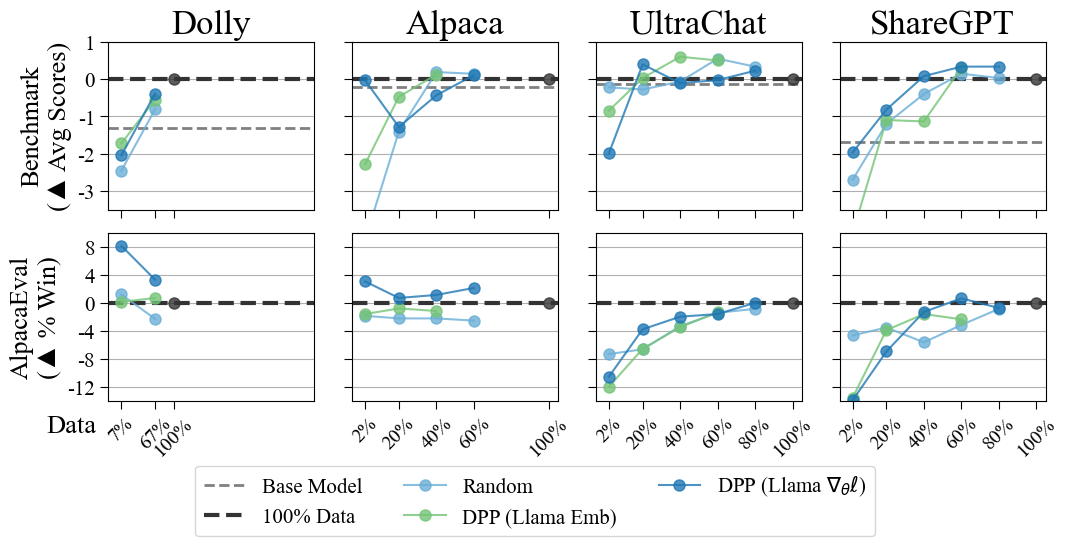

In [759]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_path = '/dccstor/data-pruning/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()


from collections import defaultdict

def get_task_name_display(task_name):
    if task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR': return 'AlpacaEval\n(% Win)'
    if task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*': return 'AlpacaEval\n(Win Rate)'
    if task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR**': return 'AlpacaEval\n(Win Rate **)'
    if task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR***': return 'AlpacaEval\n(Win Rate ***)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Len*': return 'AlpacaEval\n(Tok Length*)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Len': return 'AlpacaEval\n(Tok Length)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed': return 'AlpacaEval\n(Medium #Tokens)'
    elif task_name == 'MTBench(gpt:4)/Turn-1': return 'MT-Bench(GPT-4)/Turn-1'
    elif task_name == 'MTBench(gpt:4)/Turn-2': return 'MT-Bench(GPT-4)/Turn-2'
    elif task_name == 'MTBench(gpt:4)/Rating': return 'MT-Bench(GPT-4)/Rating'
    elif task_name == 'nonchat': return 'NLP Benchmarks\n(Average Score)'
    elif task_name == 'academic_benchmark_avg': return 'Benchmark\n(Avg Scores)'
    else: return task_name
        
def get_dataset_display(dataset):
    if 'dolly' in dataset: return 'Dolly'
    elif 'stanford_alpaca' in dataset: return 'Alpaca'
    elif 'ultrachat' in dataset: return 'UltraChat'
    elif 'sharegpt' in dataset: return 'ShareGPT'
    elif 'ultrafeedback' in dataset: return 'UltraFeedback'
    elif 'flan_v2' in dataset: return "FLAN"
    elif 'oasst2' in dataset: return "OASST2"
    elif 'wizardlm' in dataset: return "WizardLM"
    else: raise ValueError(f'{dataset} not defined display name')


data_to_compute_dict = dfc.set_index(['subset_size']).to_dict()['compute']
data_to_compute_pct = lambda x: data_to_compute_dict[x]/max(data_to_compute_dict.values())*100


plt_base_model = True
plt_full_finetune = True
xaxis_type = 'data' # 'compute'
yaxis_type = 'abs'
yaxis_type = 'delta_fullfinetune'; 
assert(yaxis_type in ['abs', 'delta_fullfinetune'])

if finetune_type == 'sft':
    datasets = ['dolly', 'stanford_alpaca50k', 'ultrachat50k', 'sharegpt50k']
    datasets = ['flan_v250k', 'dolly', 'stanford_alpaca50k', 'oasst2', 'ultrachat50k', 'wizardlm50k', 'sharegpt50k']
    datasets = ['flan_v250k', 'dolly', 'stanford_alpaca50k', 'ultrachat50k', 'wizardlm50k', 'sharegpt50k']
    datasets = ['dolly', 'stanford_alpaca50k', 'ultrachat50k', 'sharegpt50k']
else:
    datasets = ['ultrafeedback']
# datasets = list(np.unique(dfc['dataset']))

task_names = []
task_names += ['academic_benchmark_avg']
# task_names += ['nonchat']
# task_names += ['nonchat', 'MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR*',]
# task_names += ['MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1',]
# task_names += [f'MTBench({mtbench_judge})/Turn-1',  f'MTBench({mtbench_judge})/Turn-2', f'MTBench({mtbench_judge})/Rating']
# task_names += [f'MTBench({mtbench_judge})/Rating']
# task_names += [f'MTBench({mtbench_judge})/Turn-1']
task_names += [f'AlpacaFarm({alpacafarm_judge})/WR'] 
# task_names += [f'AlpacaFarm({alpacafarm_judge})/WR**'] 
# task_names += [f'AlpacaFarm({alpacafarm_judge})/WR***'] 
# task_names += [f'AlpacaFarm({alpacafarm_judge})/WR***'] 
# task_names += [f'AlpacaFarm({alpacafarm_judge})/Len*']
# task_names += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/LenMed'] # , f'AlpacaFarm({alpacafarm_judge})/Rep2'

label_baseline = 'Base Model'
full_sft_short = '100\\% Data'

cmap = plt.get_cmap('tab20c')

plt_settings = {
    'color': {
        full_sft_short: '#333333', #'#FFA500', # orange
#         'Random': 'gray',
        label_baseline: 'gray',
#         label_dpp_vmf_grad: '#3498db', # bright blue
#         label_dpp_vmf_text: '#1f618d', # dark blue
#         label_dpp_vmf_text,
#         label_dpp_rbf_grad,
#         label_dpp_rbf_text,
        'Random': cmap(1),
    #     'DPP (MpNet Emb Norm.)'
        'DPP (Llama $\\nabla_{\\theta}\\ell$ Norm.)': cmap(1+4),
        'DPP (Llama Emb)': cmap(1+8), 
        'DPP (Llama Emb Norm.)': cmap(1+12),
    },
    
    
}

plt.rcParams.update({
    'axes.titlesize': 25,   # ax title
    'axes.labelsize': 19,   # labels (x-axis and y-axis)
    'xtick.labelsize': 14,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 15,  # legend font size
})

markers_list = ['^', 'o', '*', 'x', 's', ]
markers_list = ['o']*10
lineplot_kwargs = {'marker': '.', 
#                    'markerfacecolor': 'none', 
                   'markersize': 8, 
                   'alpha': .8,
#                    'markeredgewidth': 2,
#                    'linewidth': 1.5,
                  }

w = 2.5; h = 2.5
# w = 3; h = 3
w = 2.7; h = 2.4
ncols = len(datasets)
nrows = len(task_names)
fig, axs = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), sharey='row', sharex='col')

xticks_data = defaultdict(list)

for axi, task_name in enumerate(task_names):
    d = D[task_name]
    for axj, dataset in enumerate(datasets):
        ax = axs.reshape(nrows, ncols)[axi, axj]
        dataset_size = get_dataset_size(dataset)
        is_first_subfig = (axi==0 and axj==0)

        if plt_base_model and task_name == 'academic_benchmark_avg':
            k = DKey(full_sft_short, dataset, dataset_size)
            if k in d:
                y_fullfinetune = d[k]
                y_base = base_model_perf[task_name]
                y = y_base-y_fullfinetune if yaxis_type == 'delta_fullfinetune' else y_base
                ax.axhline(y=y, linestyle='--', color=plt_settings['color'][label_baseline], label=label_baseline if is_first_subfig else None, linewidth=2)
        if plt_full_finetune:
            k = DKey(full_sft_short, dataset, dataset_size)
            if k in d:
                y = 0 if yaxis_type == 'delta_fullfinetune' else d[k]
                ax.axhline(y=y, linestyle='--', color=plt_settings['color'][full_sft_short], label='100% Data' if is_first_subfig else None, linewidth=3)

        sort_by_types = sorted(set(x.sort_by_type for x in d.keys()))[::-1]
#         sort_by_types = list(set([x.sort_by_type for x in d.keys()]))
        for i, sort_by_type in enumerate(sort_by_types):
            xs = sorted([x.subset_size for x in d.keys()
                         if x.dataset == dataset and x.sort_by_type==sort_by_type])
            xticks_data[dataset] += list(set(xs) - set(xticks_data[dataset]))

            ys = [d[DKey(sort_by_type, dataset, x)] for x in xs]
            if yaxis_type == 'delta_random':
                if not all(DKey('random', dataset, x) in d for x in xs): continue
                ys = [y-d[DKey('random', dataset, x)] for x, y in zip(xs, ys)] 
            elif yaxis_type == 'delta_fullfinetune':
                if DKey(full_sft_short, dataset, dataset_size) not in d: continue
                ys = [y-d[DKey(full_sft_short, dataset, dataset_size)] for y in ys]
            kwargs = {}
            if sort_by_type in plt_settings['color']:
                kwargs['color'] = plt_settings['color'][sort_by_type]
            if full_sft_short not in sort_by_type and is_first_subfig:
                kwargs['label'] = sort_by_type 
            kwargs.update(lineplot_kwargs)
            kwargs.update({'marker': markers_list[i]})
            xs = xs if xaxis_type == 'data' else [data_to_compute_pct(x) for x in xs]
#             print(task_name, dataset, sort_by_type, xs, ys)
            ax.plot(xs, ys, **kwargs)
            ax.grid(visible=True, axis='y')
            ax.tick_params(axis='both', which='both', length=6) 
            ax.locator_params(nbins=4, axis='both')


## left most subfigure set ylabel & yticks
for axi, task_name in enumerate(task_names):
    task_name_shortened = get_task_name_display(task_name)
    ax = axs.reshape(nrows, ncols)[axi, 0]
    ax.set_ylabel(task_name_shortened.replace('(', '(▲ ') if yaxis_type.startswith('delta') else task_name_shortened, va='bottom')
    if yaxis_type == 'delta_fullfinetune':
        if task_name == 'academic_benchmark_avg': yticks = [-3,-2,-1,0,1]
        elif 'AlpacaFarm' in task_name and 'WR' in task_name: yticks = [-12, -8, -4, 0, 4, 8]
        else: yticks = None
        if yticks is not None: ax.set_yticks(yticks, yticks)
    

for axj, dataset in enumerate(datasets):
    dataset_size = get_dataset_size(dataset)
    xticks = np.array(sorted(xticks_data[dataset]))
    ax = axs.reshape(nrows, ncols)[nrows-1, axj]
    c = .05; ax.set_xlim((-N*c, N+c*N))
    xticklabels = [f'{x*100:.0f}%' for x in xticks/get_dataset_size(dataset)]
    ax.set_xticks(xticks, xticklabels, ha='center', rotation=45)

    ax = axs.reshape(nrows, ncols)[0, axj]
    ax.set_title(get_dataset_display(dataset))

    if yaxis_type != 'abs':
        axs.reshape(nrows, ncols)[0, axj].set_ylim((-3.5, 1))
        axs.reshape(nrows, ncols)[1, axj].set_ylim((-14, 10))
        
        
## data xlabel at the side s
axs.reshape(nrows, ncols)[nrows-1, 0].annotate('Data', xy=(-0.3, -.15), xycoords="axes fraction", ha='left', va='center', weight='bold', fontsize=plt.rcParams['axes.labelsize'])
## legend at bottom
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -.15), ncol=3, frameon=True)


fig.tight_layout()

save_plt = True
if save_plt:
    save_path = os.path.join(assets_dir, 'fig_vmf_grad_vs_random_cross_datasets.pdf')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

